In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Cropping2D, Cropping3D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import glob
from PIL import Image
from sklearn import metrics, cross_validation


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set some parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
#samples = [file for file in glob.glob('data/images/64x64/*.png')]
#masks = [file for file in glob.glob('data/masks/64x64/*.npy')]
train_files = [file for file in glob.glob('data/images/64x64/train/*.png')]
test_files = [file for file in glob.glob('data/images/64x64/test/*.png')]

In [3]:
print(len(train_files))
print(len(test_files))

24025
980


In [4]:
import cv2

def normalize_rgb(x):
    b=x[:,:,0]
    g=x[:,:,1]
    r=x[:,:,2]
    
    sum=b+g+r

    norm=np.zeros((IMG_WIDTH,IMG_HEIGHT,3),np.float32)
    norm_rgb=np.zeros((IMG_WIDTH,IMG_HEIGHT,3),np.uint8)
    norm[:,:,0]=b/sum*255.0
    norm[:,:,1]=g/sum*255.0
    norm[:,:,2]=r/sum*255.0
    
    norm_rgb=cv2.convertScaleAbs(norm)
    return norm_rgb

def load_X_y(files, masks_dir):
    X = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y = np.zeros((len(files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
    for n, file in enumerate(files):
        X[n] = imread(file)
        mask_ = np.load(masks_dir + os.path.basename(file)[:-4] + '.npy')
        y[n] = np.expand_dims(mask_, axis=-1)
    return X, y
X_train, y_train = load_X_y(train_files, 'data/masks/64x64/train/')
X_test, y_test = load_X_y(test_files, 'data/masks/64x64/test/')
print(X_train.shape)
print(X_test.shape)

(24025, 64, 64, 3)
(980, 64, 64, 3)


/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


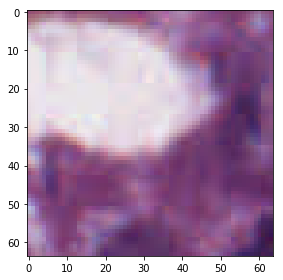

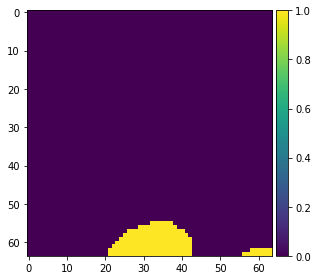

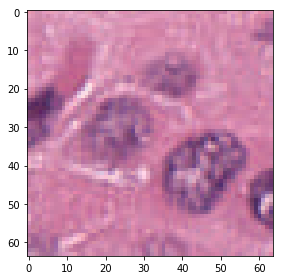

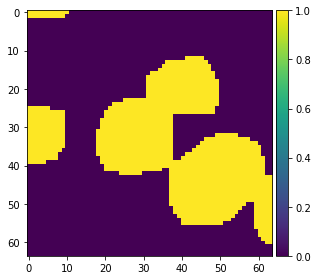

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

ix = random.randint(0, len(X_test))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(y_test[ix]))
plt.show()

In [6]:
# Dice coefficient
def dice_coef(y_true, y_pred):
#    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true - y_pred * y_true)
    score = 2 * intersection / (union + intersection)
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def iou(y_true, y_pred):
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true) - intersection
    score = intersection / union
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def accuracy(y_true, y_pred):
    acc = K.mean(y_pred == y_train)
    K.get_session().run(tf.local_variables_initializer())
    acc = tf.identity(acc)
    return acc

In [67]:
# MODEL_NAME = 'model-fullsize-64x64-norm-transpose-no-max.h5'
# MODEL_NAME = 'model-fullsize-64x64-transpose-no-max.h5'
# MODEL_NAME = 'model-fullsize-64x64-transpose-max.h5'
# MODEL_NAME = 'model-fullsize-64x64-upsampling-max_2.h5'
MODEL_NAME = 'model-fullsize-64x64-upsampling-max-elu_3.h5'

In [68]:
from keras.layers import ELU, Dropout

activation = ELU()
activation.__name__ = 'ELU'

drop_rate = 0.2

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: (x - 128)/128) (inputs)

c1 = Conv2D(64, (3, 3), activation=activation, padding='same') (s)
# c1 = Dropout(rate=drop_rate)(c1)
c1 = Conv2D(64, (3, 3), activation=activation, padding='same') (c1)
# p1 = Conv2D(64, (2, 2), activation=activation, strides=(2,2), padding='valid') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(128, (3, 3), activation=activation, padding='same') (p1)
# c2 = Dropout(rate=drop_rate)(c2)
c2 = Conv2D(128, (3, 3), activation=activation, padding='same') (c2)
# p2 = Conv2D(128, (2, 2), activation=activation, strides=(2,2), padding='valid') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(256, (3, 3), activation=activation, padding='same') (p2)
c3 = Dropout(rate=drop_rate)(c3)
c3 = Conv2D(256, (3, 3), activation=activation, padding='same') (c3)
# p3 = Conv2D(256, (2, 2), activation=activation, strides=(2,2), padding='valid') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation=activation, padding='same') (p3)
c4 = Dropout(rate=drop_rate)(c4)
c4 = Conv2D(512, (3, 3), activation=activation, padding='same') (c4)
# p4 = Conv2D(512, (2, 2), activation=activation, strides=(2,2), padding='valid') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(1024, (3, 3), activation=activation, padding='same') (p4)
c5 = Dropout(rate=drop_rate)(c5)
c5 = Conv2D(1024, (3, 3), activation=activation, padding='same') (c5)

# u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = UpSampling2D(size=(2, 2))(c5)
u6 = Cropping2D(cropping=(0, 256), dim_ordering='th')(u6)
u6 = concatenate([u6, c4])

c6 = Conv2D(512, (3, 3), activation=activation, padding='same') (u6)
c6 = Dropout(rate=drop_rate)(c6)
c6 = Conv2D(512, (3, 3), activation=activation, padding='same') (c6)

# u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = UpSampling2D(size=(2, 2))(c6)
u7 = Cropping2D(cropping=(0, 128), dim_ordering='th')(u7)
u7 = concatenate([u7, c3])

c7 = Conv2D(256, (3, 3), activation=activation, padding='same') (u7)
c7 = Dropout(rate=drop_rate)(c7)
c7 = Conv2D(256, (3, 3), activation=activation, padding='same') (c7)

# u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = UpSampling2D(size=(2, 2))(c7)
u8 = Cropping2D(cropping=(0, 64), dim_ordering='th')(u8)
u8 = concatenate([u8, c2])

c8 = Conv2D(128, (3, 3), activation=activation, padding='same') (u8)
# c8 = Dropout(rate=drop_rate)(c8)
c8 = Conv2D(128, (3, 3), activation=activation, padding='same') (c8)

# u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = UpSampling2D(size=(2, 2))(c8)
u9 = Cropping2D(cropping=(0, 32), dim_ordering='th')(u9)
u9 = concatenate([u9, c1], axis=3)

c9 = Conv2D(64, (3, 3), activation=activation, padding='same') (u9)
# c9 = Dropout(rate=drop_rate)(c9)
c9 = Conv2D(64, (3, 3), activation=activation, padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:197: UserWarning: Do not pass a layer instance (such as ELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Cropping2D` call to the Keras 2 API: `Cropping2D(cropping=(0, 256), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Cropping2D` call to the Keras 2 API: `Cropping2D(cropping=(0, 128), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Cropping2D` call to the Keras 2 API: `Cropping2D(cropping=(0, 64), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Update your `Cropping2D` call to the Keras 2 API: `Cr

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 64, 64, 3)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 64, 64, 64)   1792        lambda_10[0][0]                  
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 64, 64, 64)   36928       conv2d_172[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [62]:
def dice_coef_np(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred + y_true)
    return 2 * intersection / union

def f1_np(y_pred, y_true):
    from sklearn.metrics import f1_score
    y_pred_reshaped = np.reshape(y_pred, (y_pred.shape[0] * IMG_WIDTH * IMG_HEIGHT, 1))
    y_true_reshaped = np.reshape(y_true, (y_true.shape[0] * IMG_WIDTH * IMG_HEIGHT, 1))
    return f1_score(y_true_reshaped, y_pred_reshaped, average=None)

def test(model, samples, ground_truth):
    preds_test = model.predict(samples, verbose=1)

    # Threshold predictions
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    print('dice_coef_np:')
    print(dice_coef_np(preds_test_t, ground_truth))

    print('')

    print('accuracy')
    print(np.mean(preds_test_t == ground_truth))

from keras.callbacks import Callback

class TestCallback(Callback):
    def on_epoch_begin(self, epoch, logs={}):
        test(model, X_test, y_test)

In [63]:
# Fit model
# model = load_model(MODEL_NAME, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(MODEL_NAME, verbose=1, save_best_only=True)
testcallback = TestCallback()
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=60, 
                    callbacks=[earlystopper, checkpointer, testcallback])

Train on 21622 samples, validate on 2403 samples
Epoch 1/60
980/980 [==============================] - 4s 4ms/step
dice_coef_np:
0.5977578624990052

accuracy
0.8048257633131377
21622/21622 [==============================] - 105s 5ms/step - loss: 0.5050 - dice_coef: 0.6144 - val_loss: 0.3327 - val_dice_coef: 0.6817

Epoch 00001: val_loss improved from inf to 0.33269, saving model to model-fullsize-64x64-upsampling-max-elu_4.h5
Epoch 2/60
980/980 [==============================] - 1s 1ms/step
dice_coef_np:
0.8067942717254404

accuracy
0.8961682378029336
21622/21622 [==============================] - 101s 5ms/step - loss: 0.3212 - dice_coef: 0.7070 - val_loss: 0.2987 - val_dice_coef: 0.7358

Epoch 00002: val_loss improved from 0.33269 to 0.29871, saving model to model-fullsize-64x64-upsampling-max-elu_4.h5
Epoch 3/60
980/980 [==============================] - 1s 1ms/step
dice_coef_np:
0.7846647531002261

accuracy
0.8963862205038265
21622/21622 [==============================] - 101s 5ms/s

In [69]:
# Predict on train, val and test
model = load_model(MODEL_NAME, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'ELU':activation})


In [70]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

980/980 [==============================] - 1s 1ms/step


In [71]:
print('dice_coef_np:')
print(dice_coef_np(preds_train_t, y_train[:int(y_train.shape[0]*0.9)]))
print(dice_coef_np(preds_val_t, y_train[int(y_train.shape[0]*0.9):]))
print(dice_coef_np(preds_test_t, y_test))

print('')

print('accuracy')
print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

print('')

print('f1')
print(f1_np(preds_train_t, y_train[:int(y_train.shape[0]*0.9)]))
print(f1_np(preds_val_t, y_train[int(y_train.shape[0]*0.9):]))
print(f1_np(preds_test_t, y_test))

dice_coef_np:
0.9635797776661648
0.9352401042021465
0.834963856234017

accuracy
0.9751783213422671
0.9551845999791927
0.9146290058992347

f1
[0.9811738  0.96357978]
[0.96573683 0.9352401 ]
[0.94242246 0.83496386]


In [69]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(preds_test[i])

/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


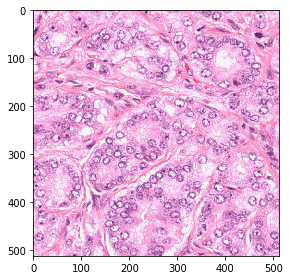

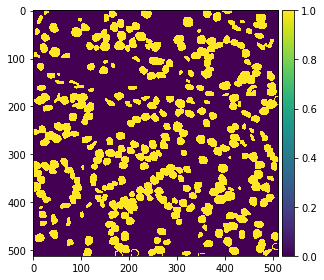

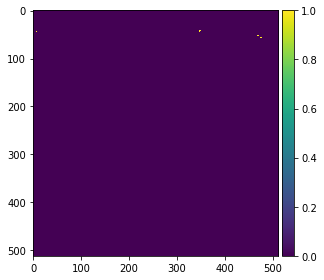

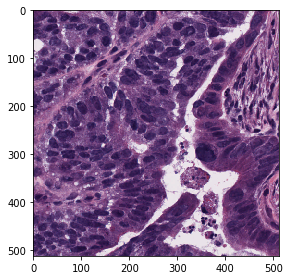

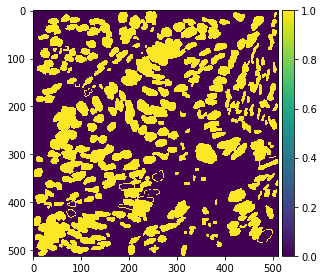

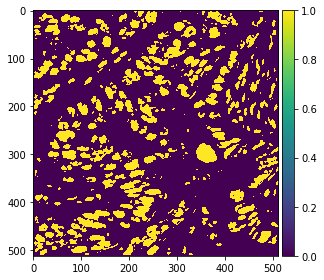

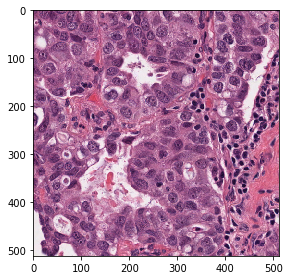

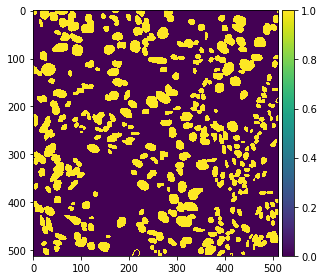

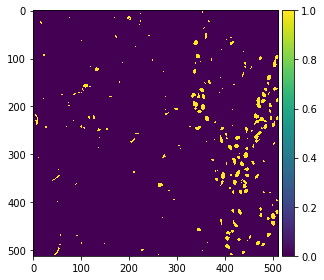

In [106]:
# Perform a sanity check on some random training samples
for _ in range(0, 3):
    ix = random.randint(0, len(preds_train_t))
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(y_train[ix]))
    plt.show()
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()

/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


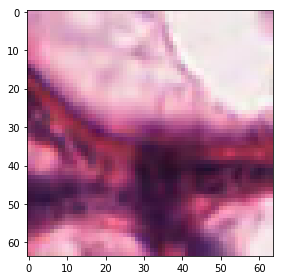

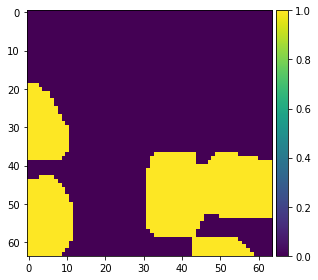

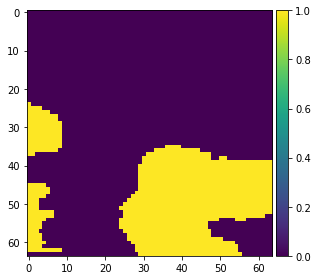

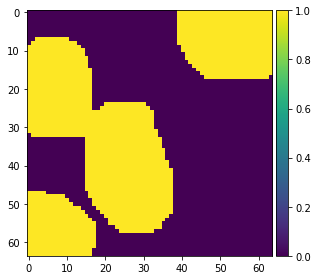

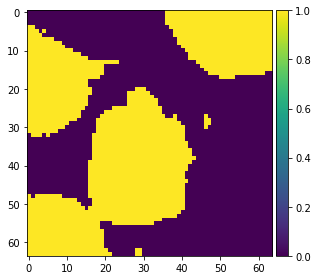

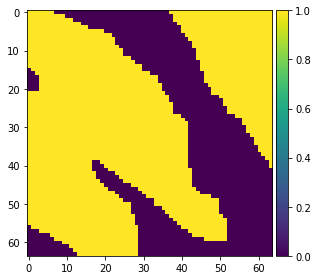

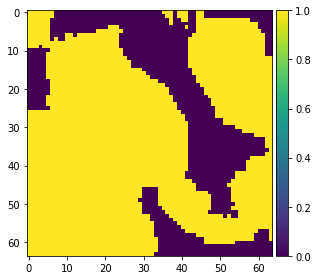

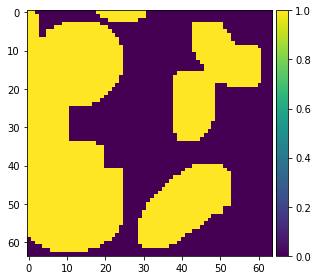

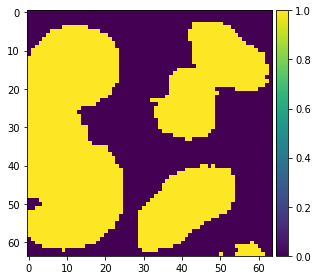

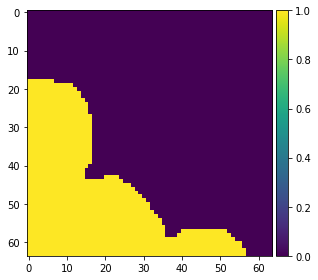

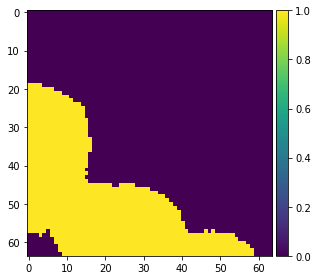

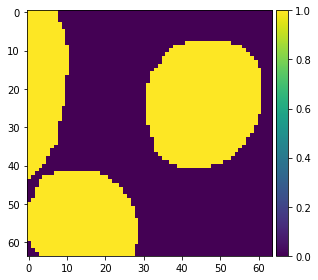

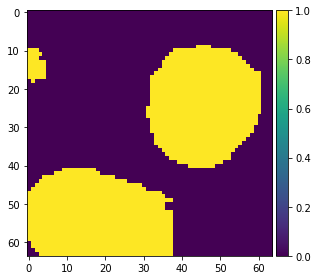

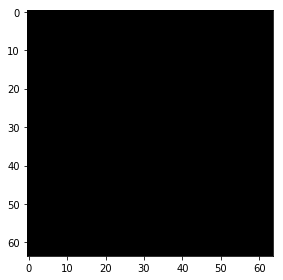

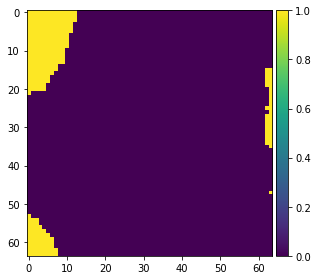

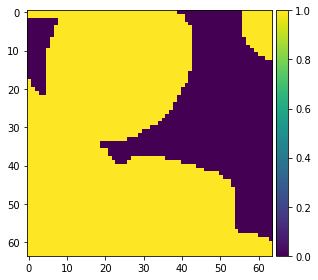

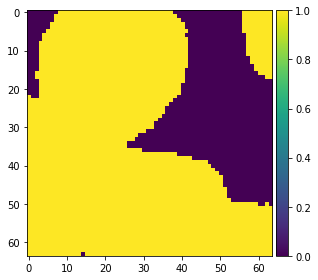

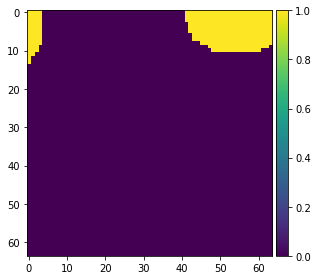

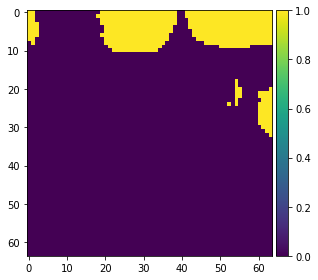

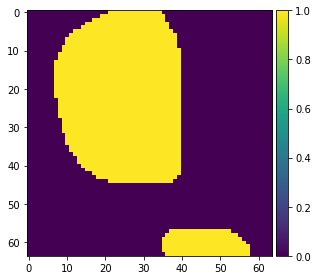

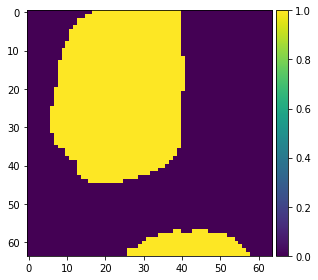

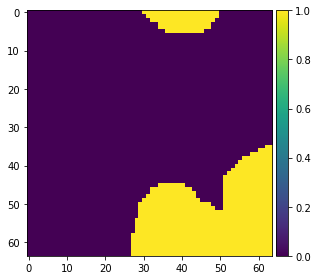

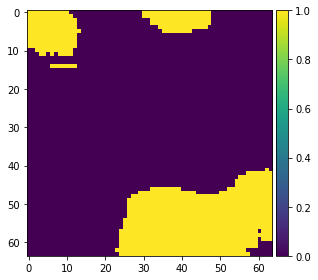

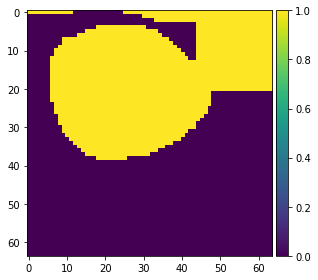

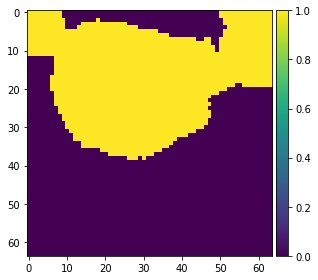

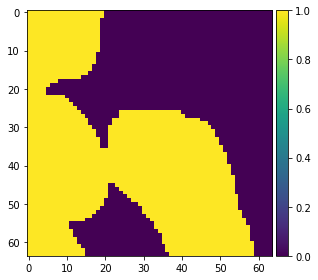

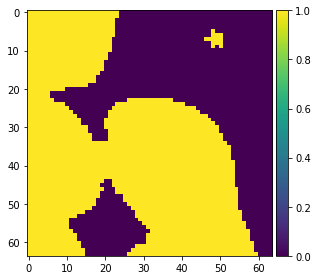

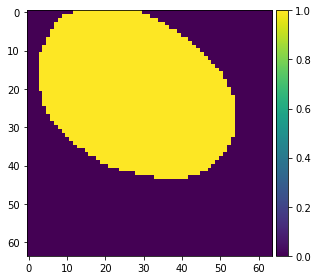

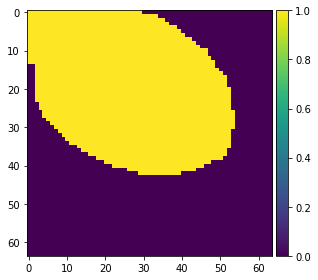

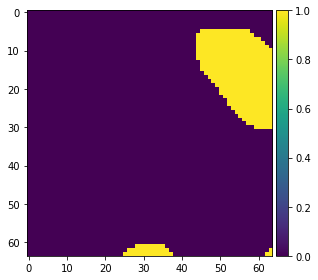

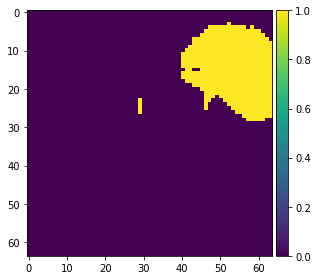

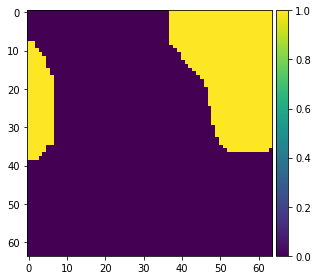

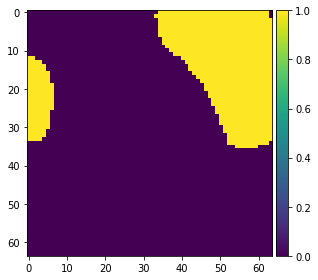

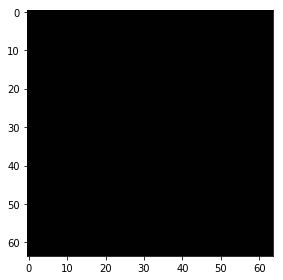

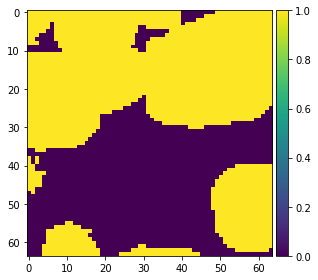

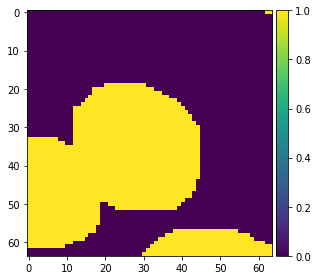

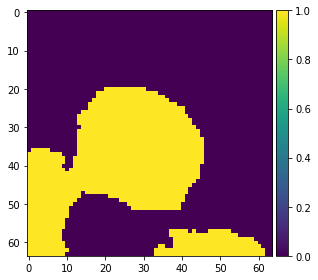

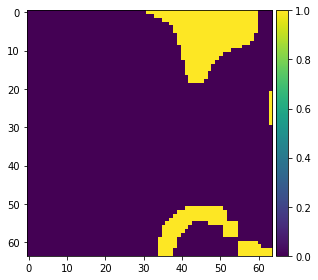

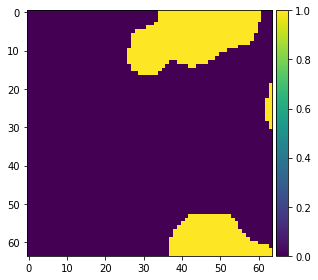

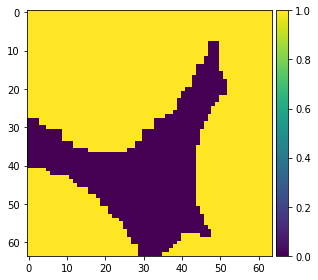

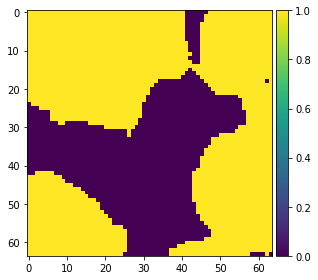

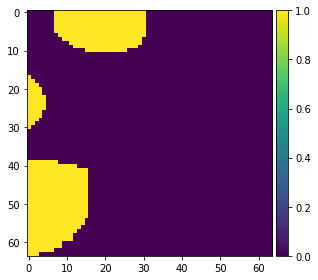

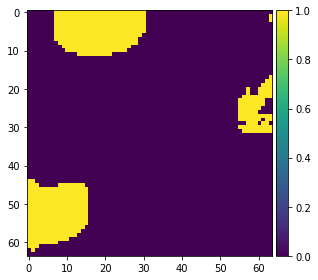

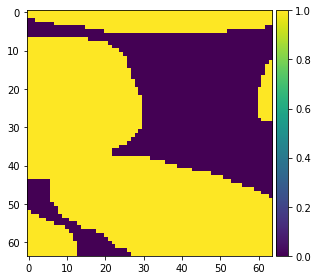

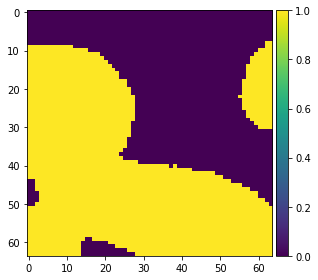

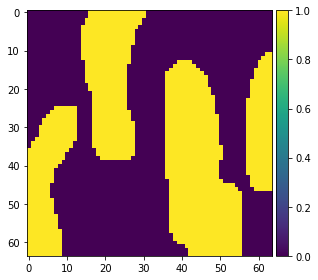

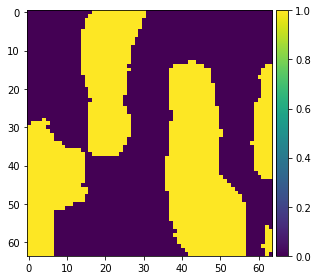

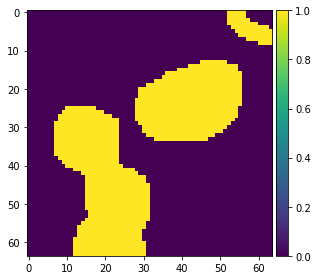

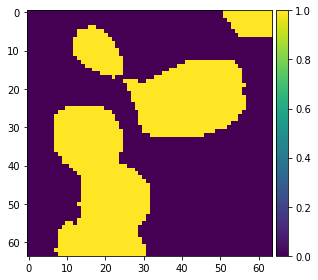

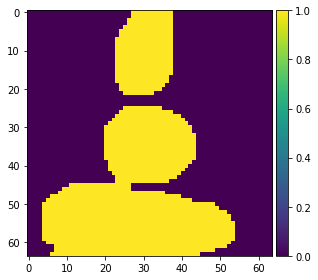

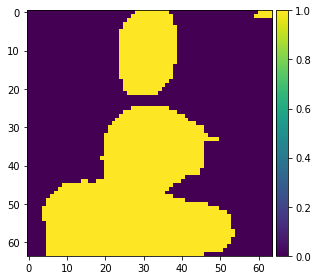

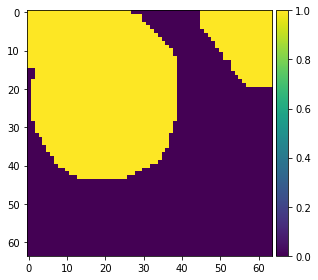

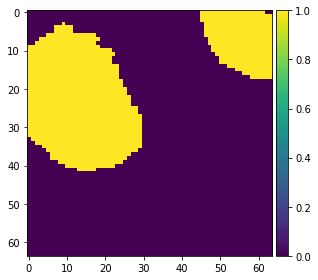

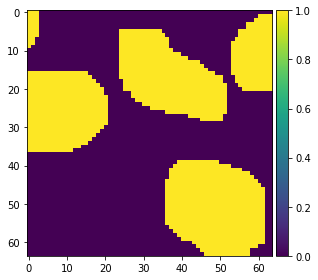

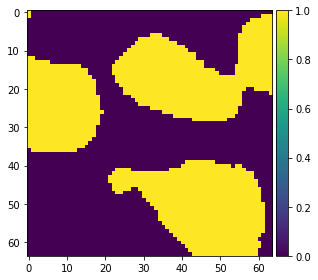

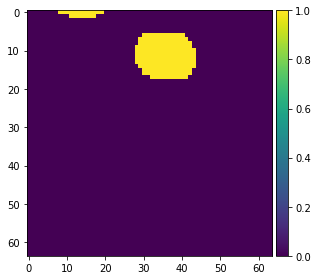

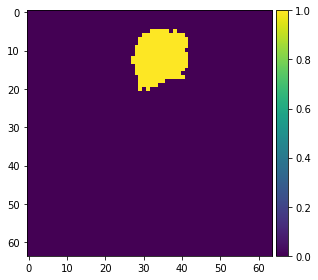

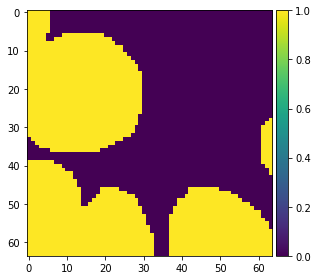

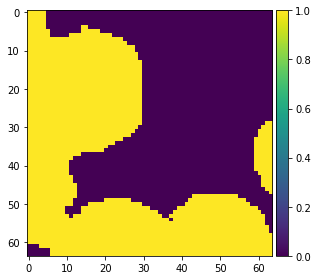

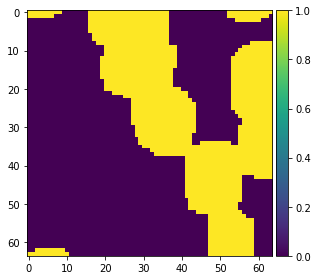

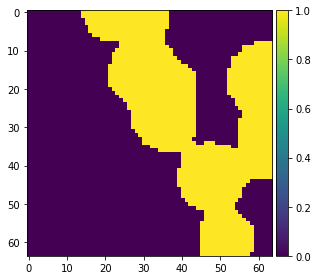

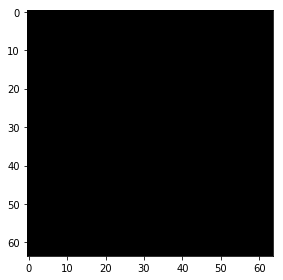

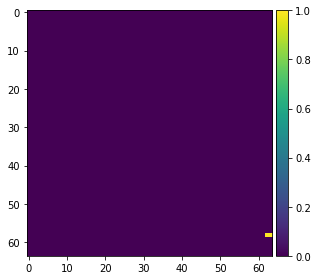

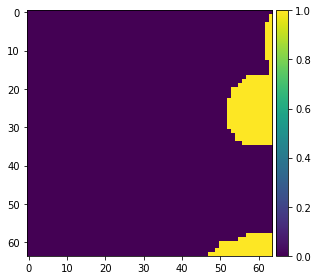

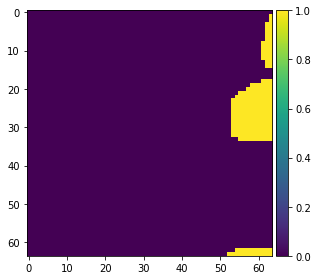

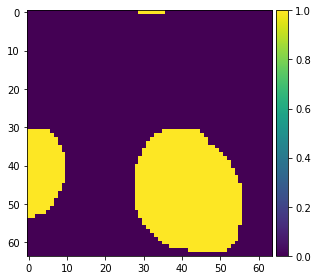

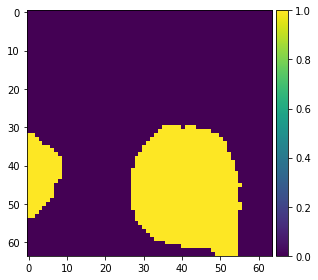

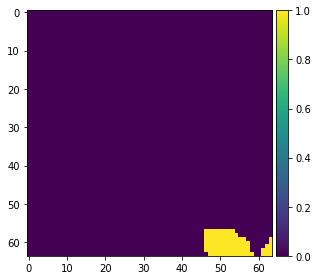

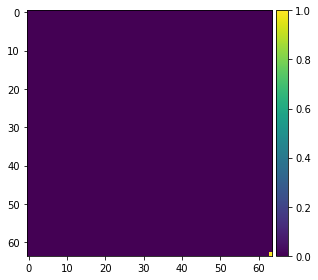

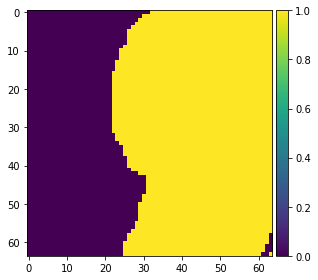

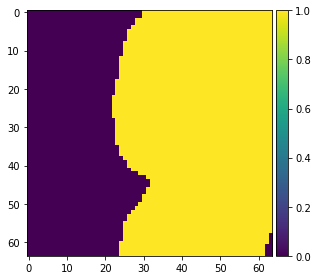

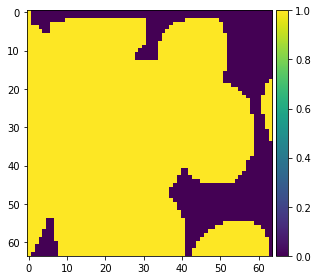

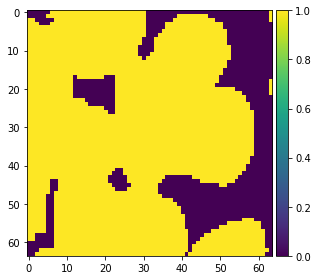

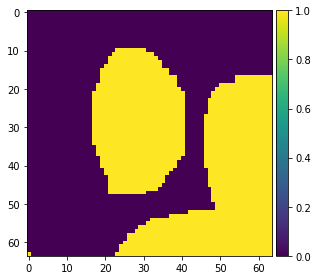

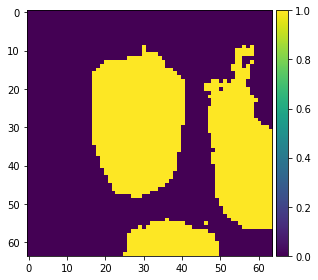

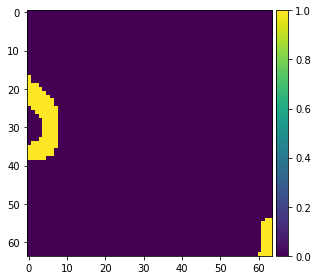

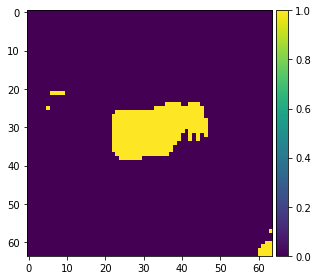

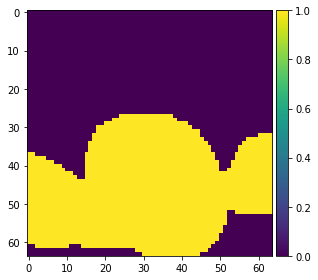

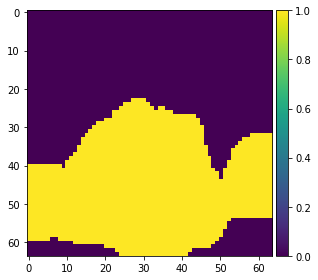

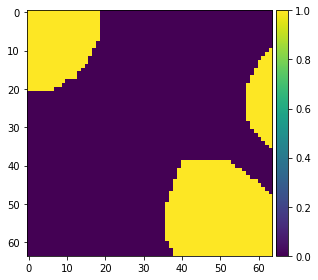

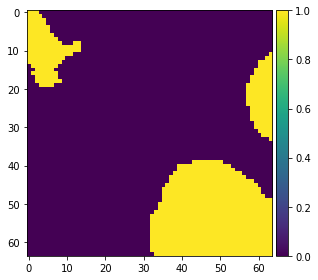

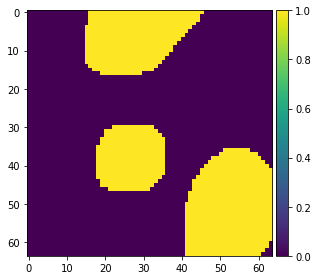

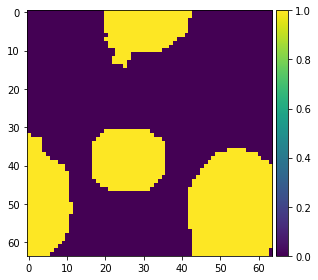

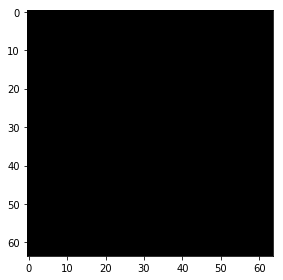

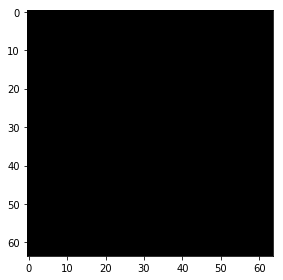

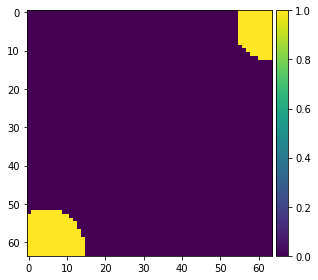

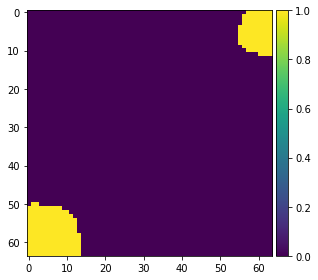

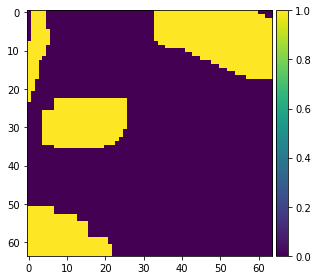

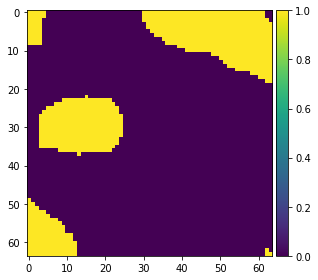

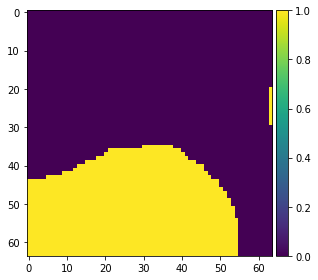

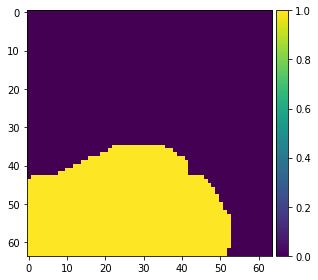

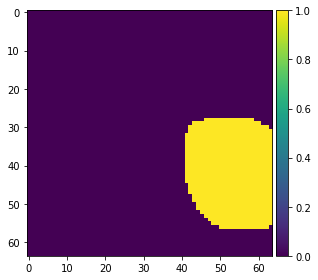

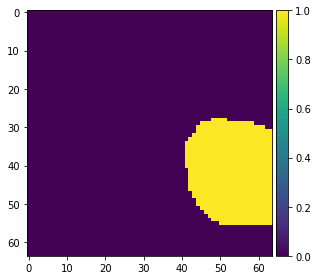

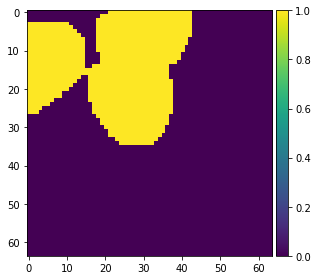

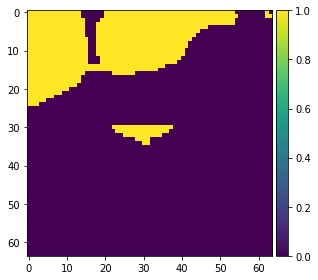

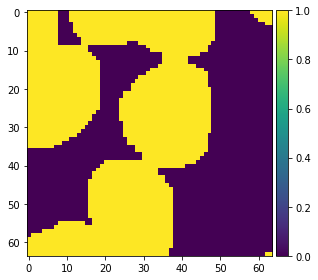

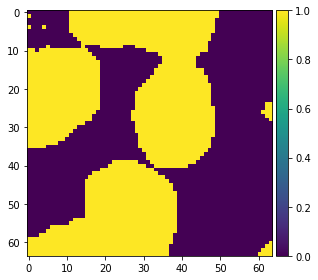

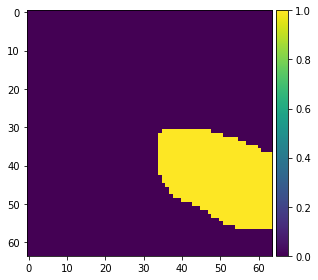

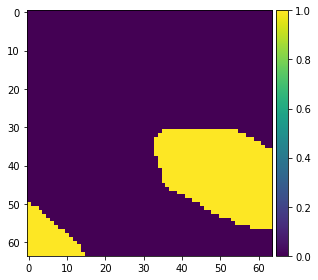

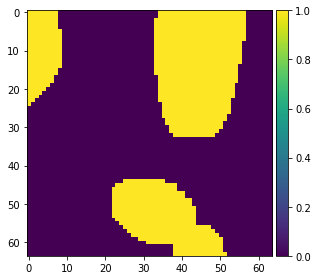

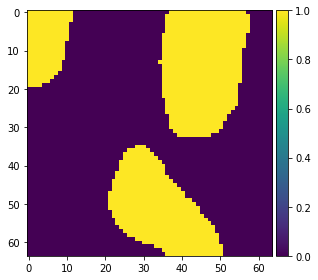

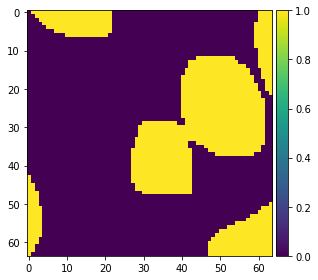

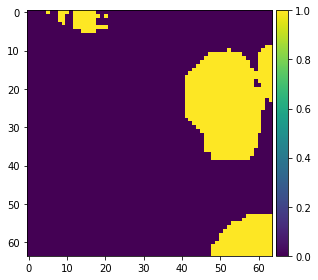

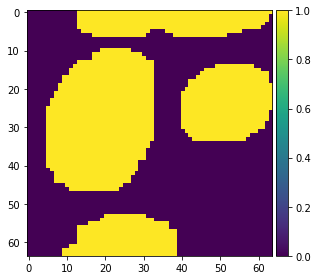

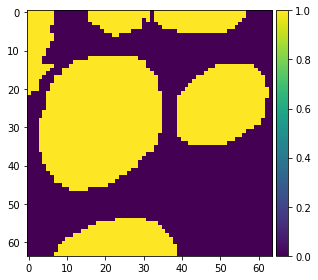

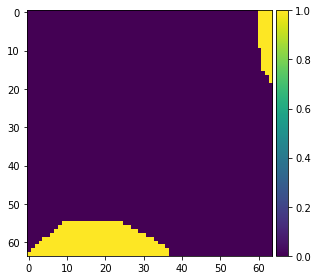

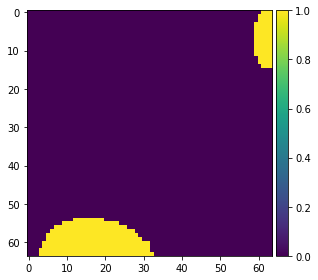

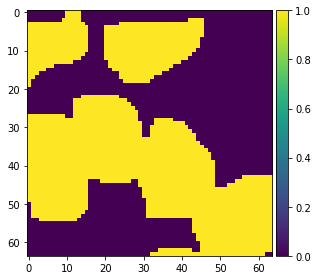

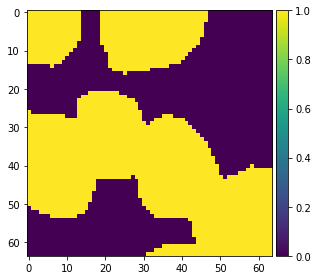

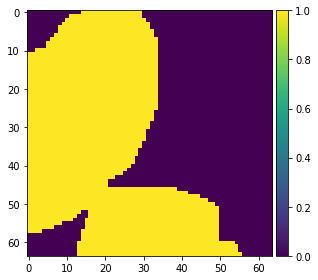

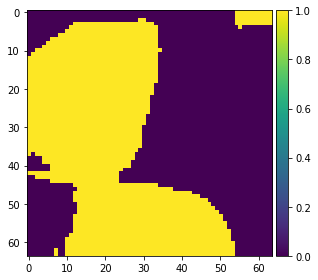

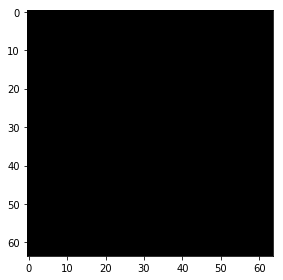

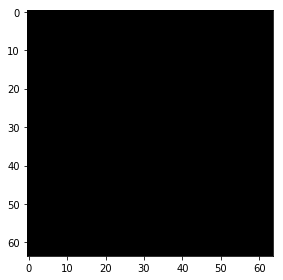

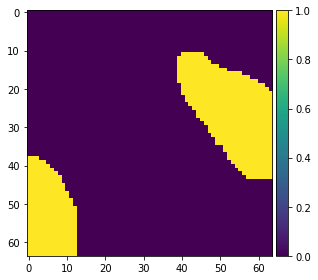

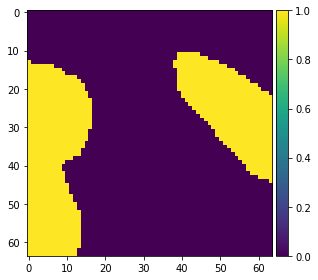

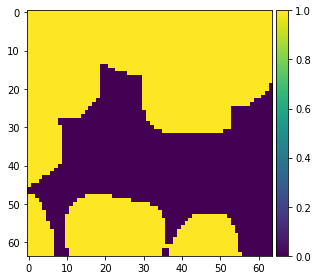

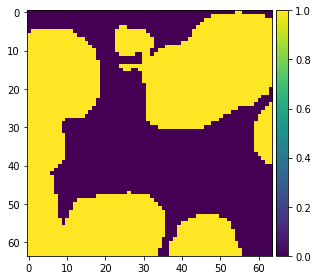

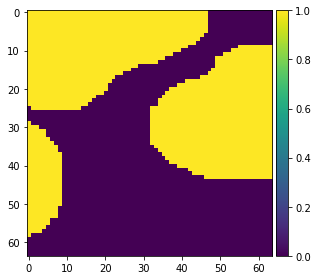

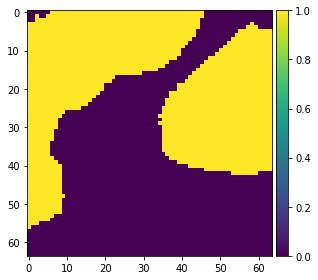

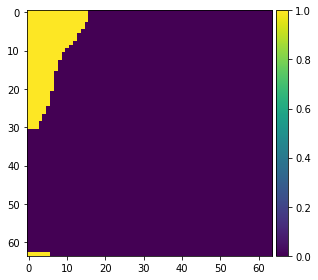

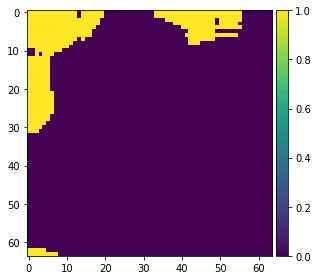

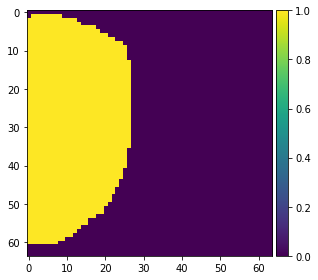

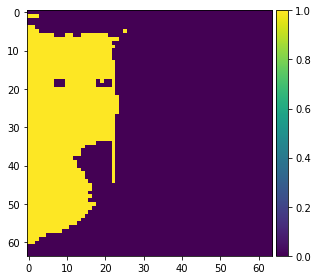

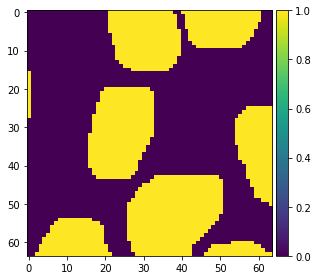

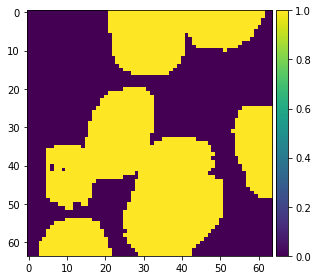

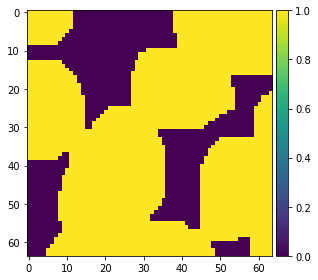

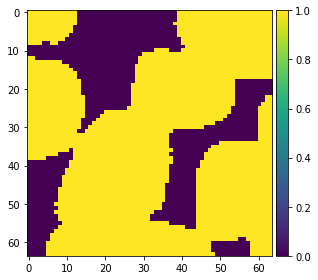

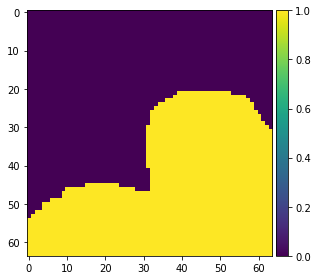

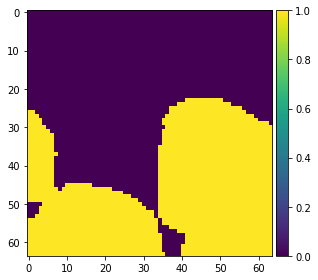

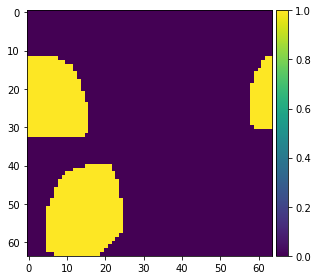

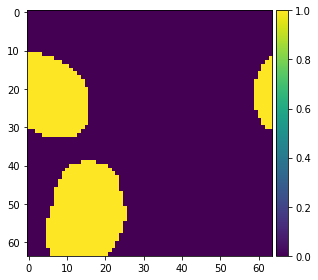

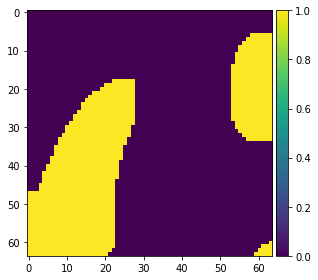

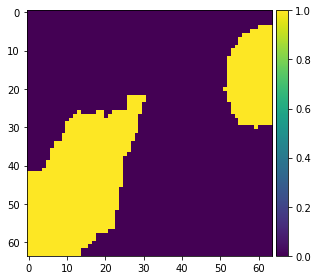

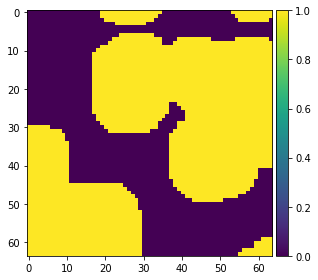

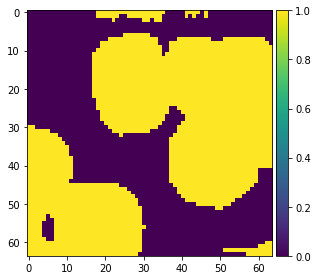

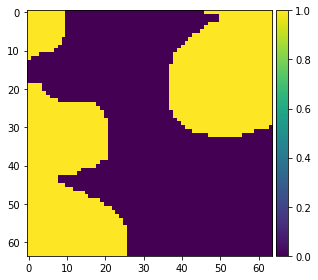

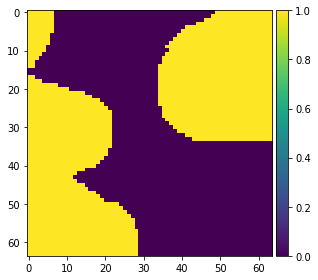

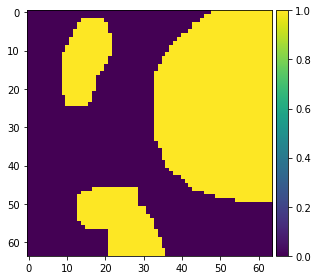

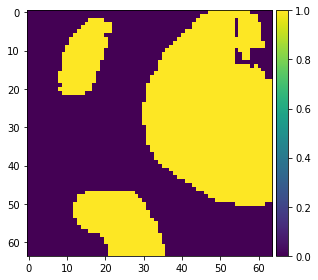

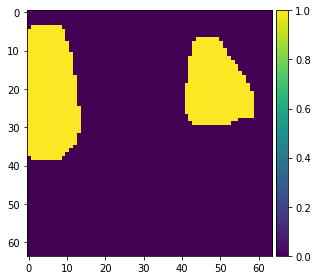

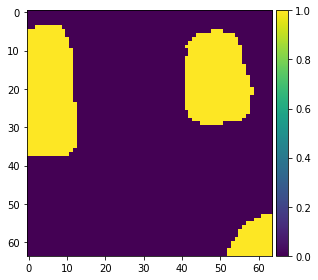

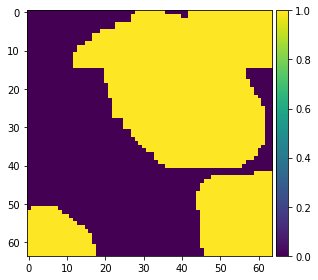

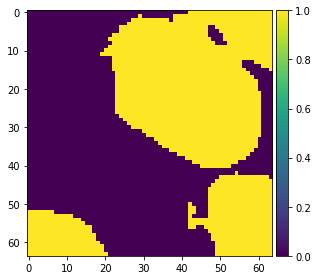

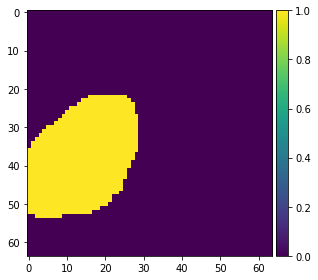

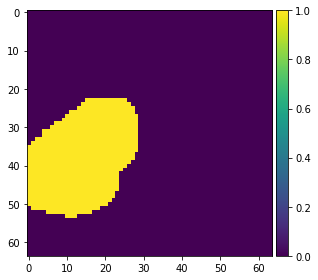

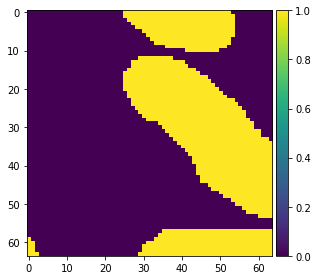

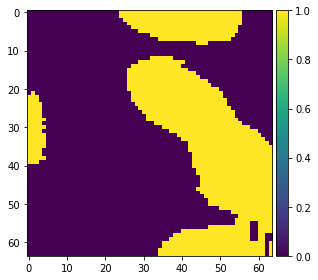

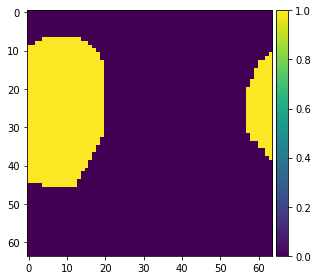

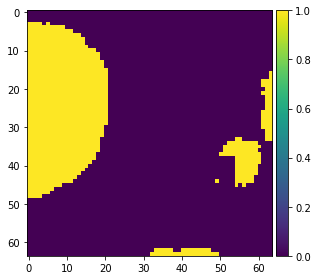

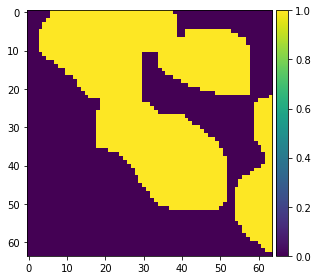

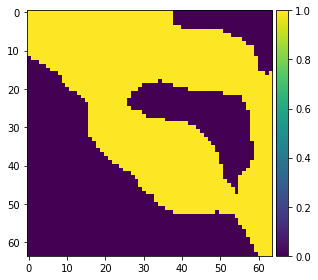

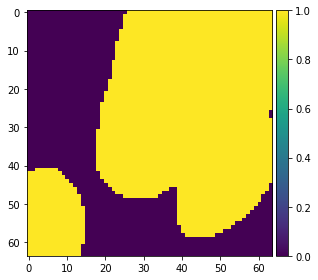

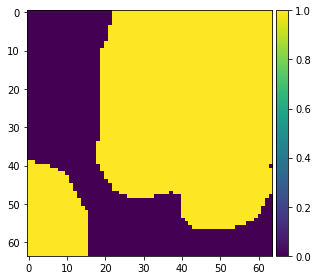

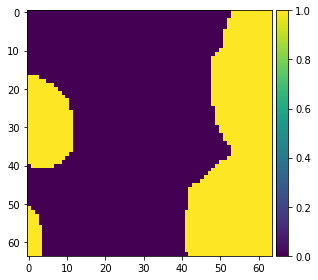

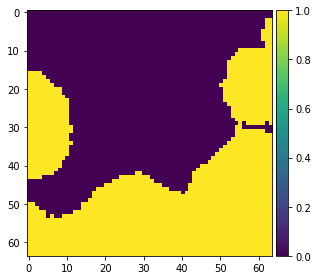

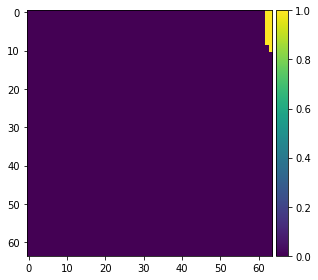

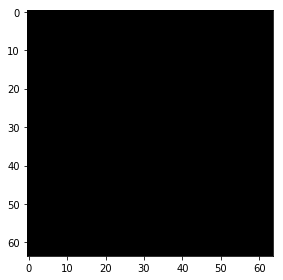

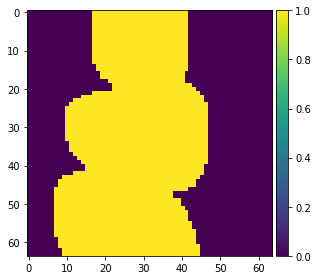

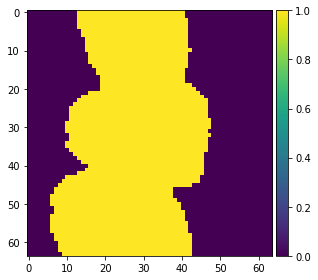

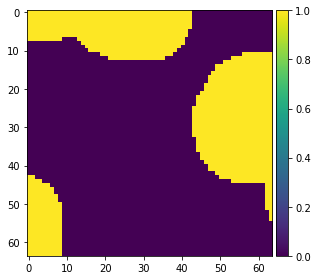

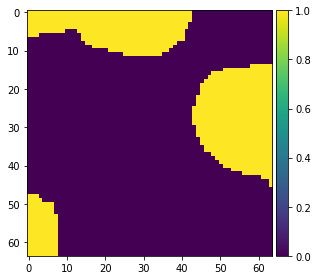

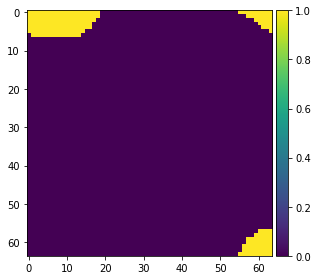

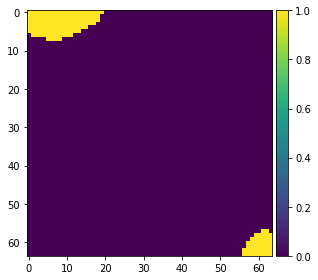

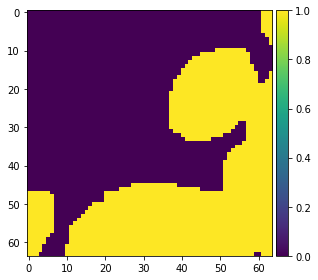

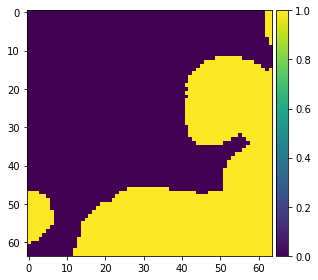

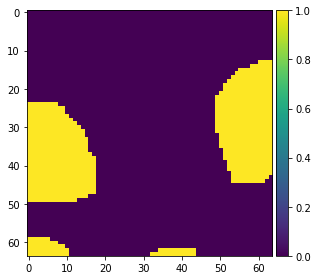

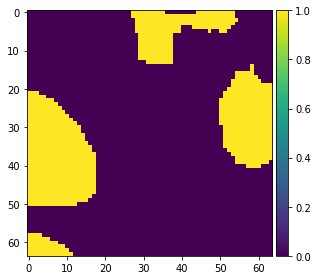

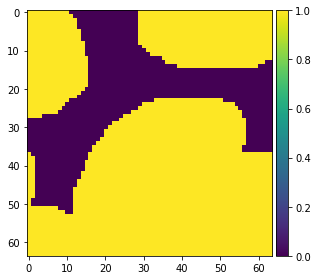

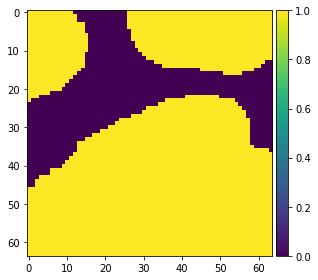

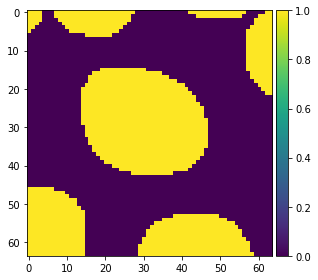

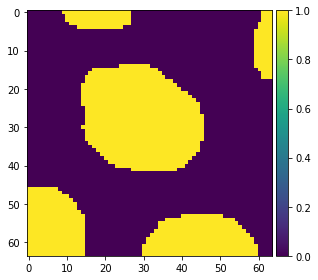

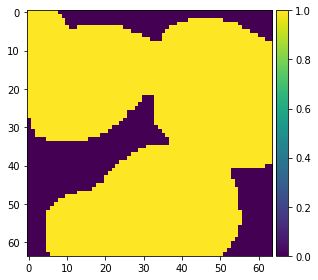

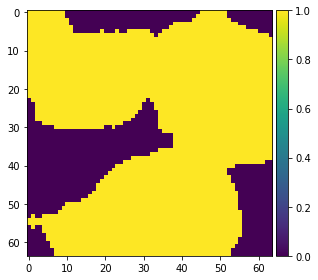

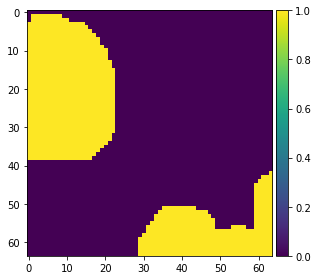

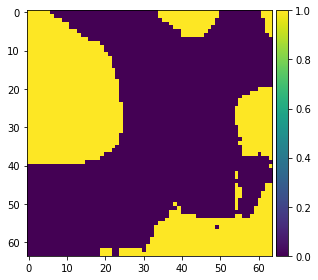

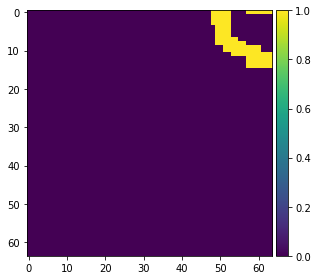

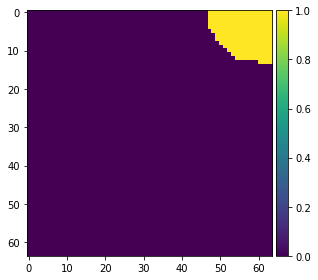

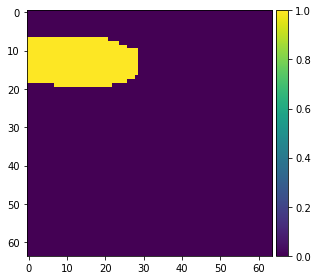

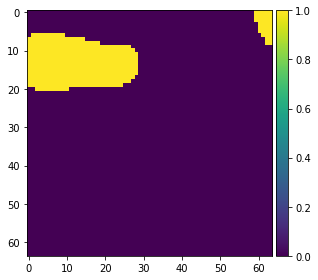

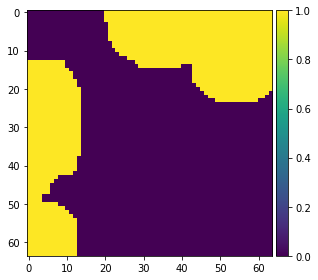

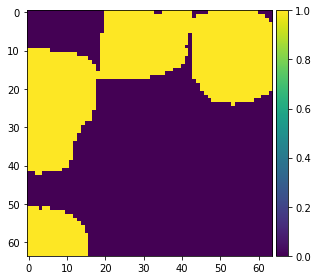

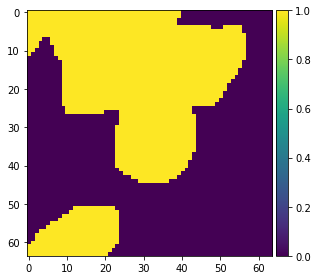

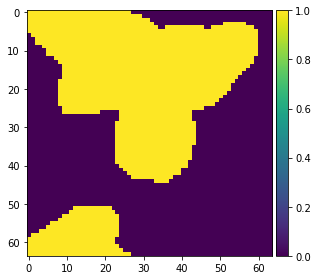

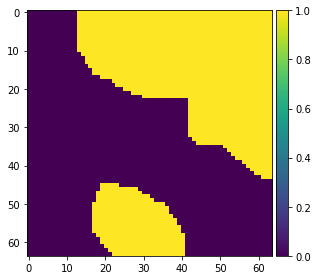

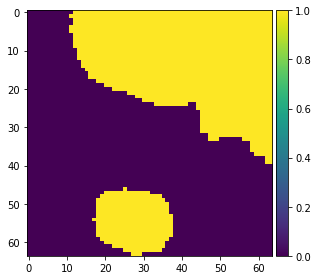

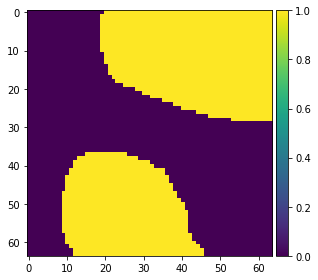

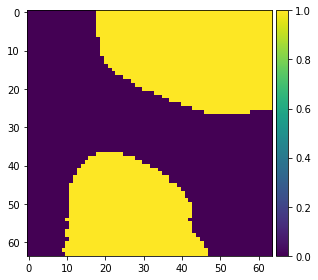

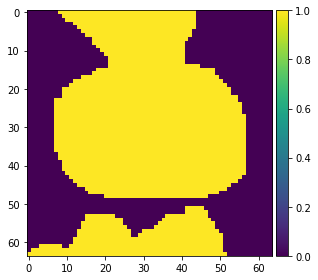

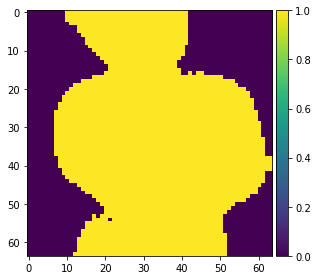

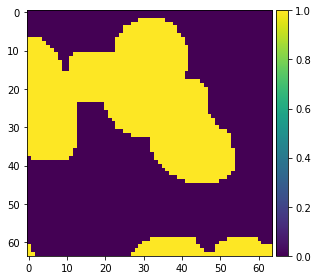

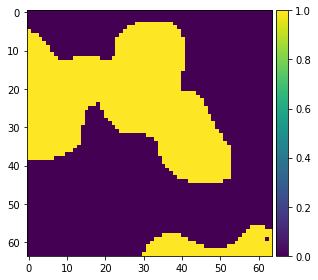

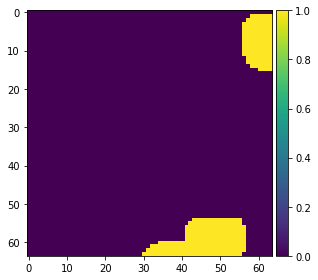

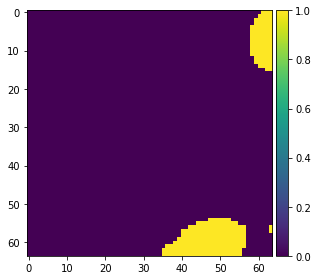

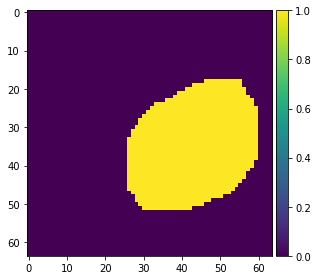

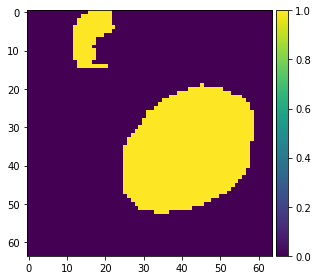

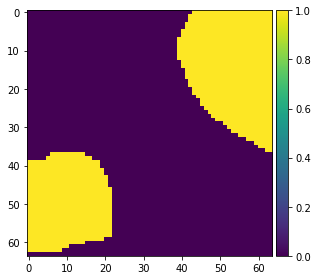

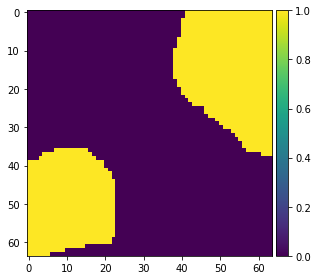

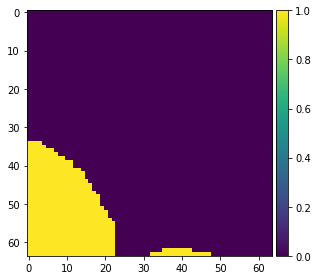

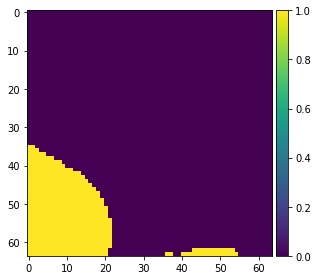

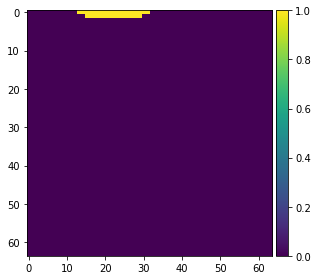

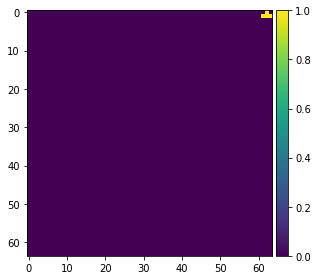

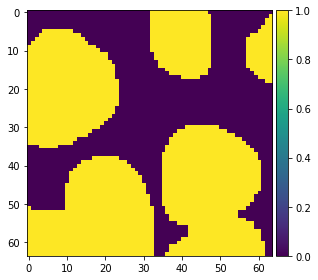

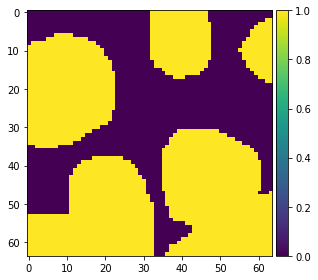

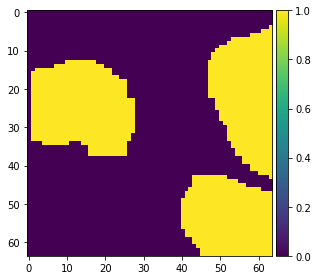

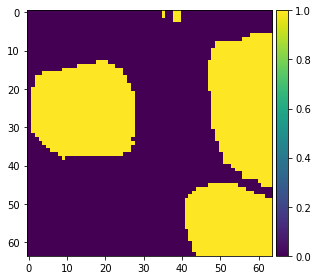

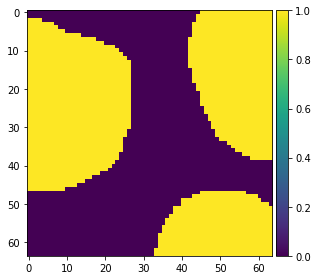

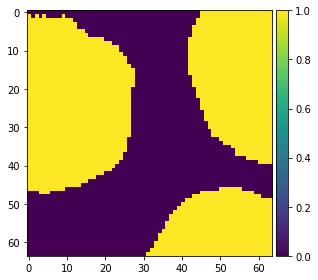

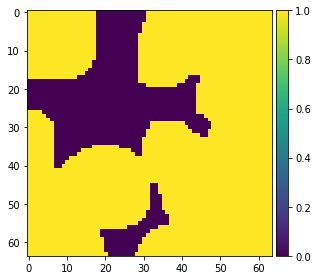

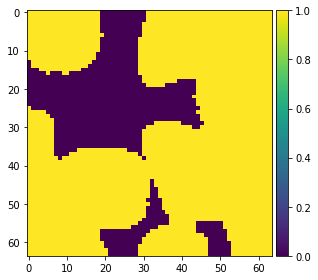

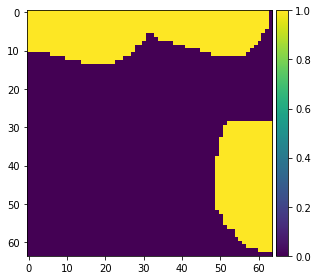

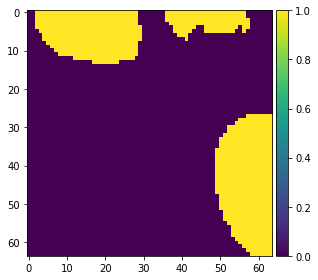

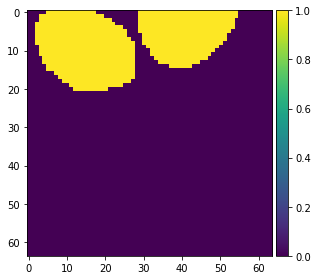

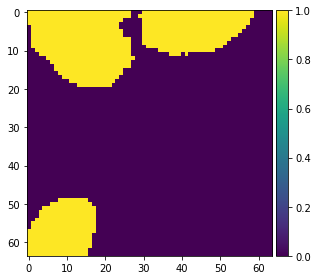

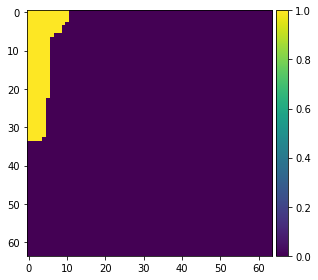

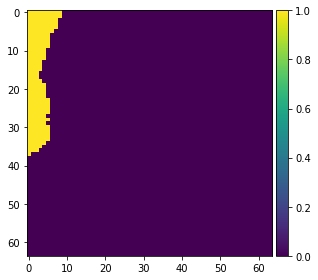

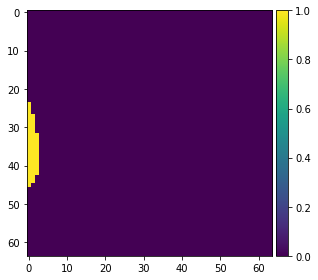

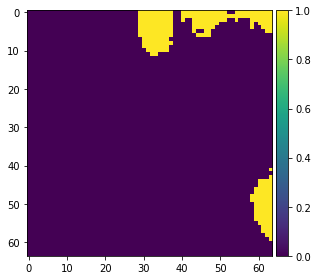

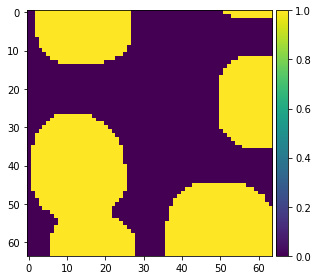

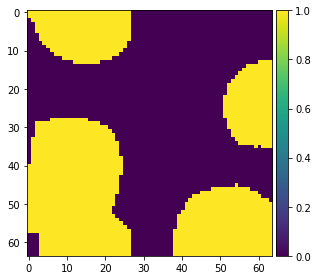

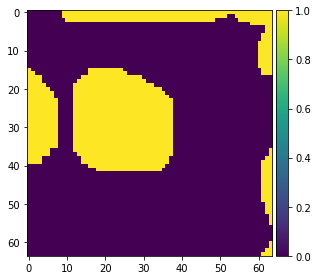

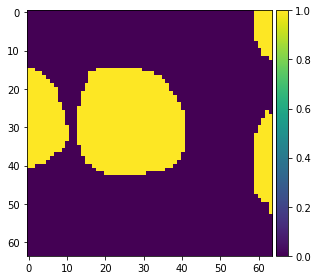

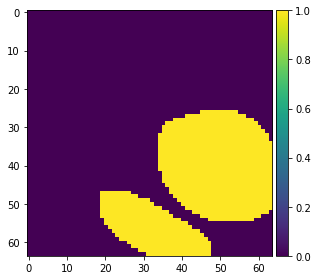

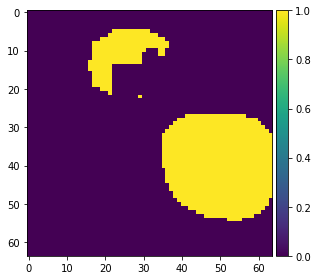

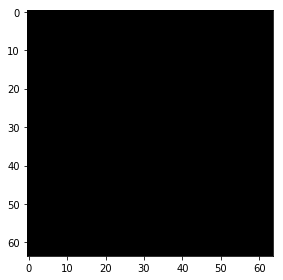

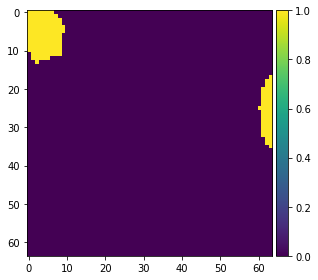

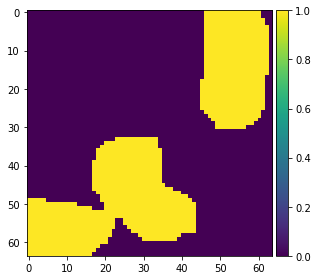

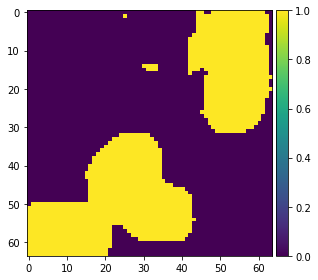

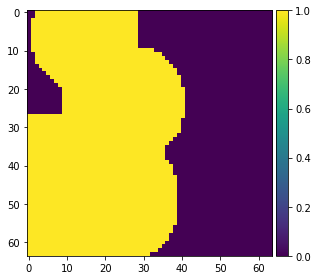

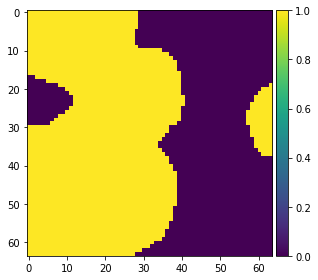

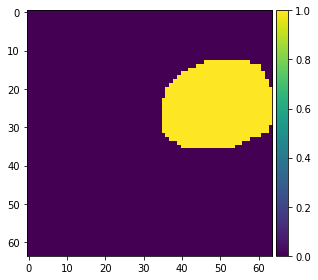

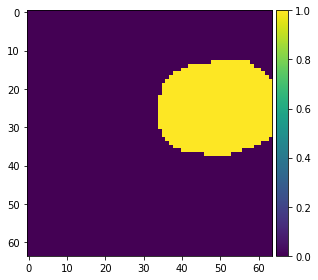

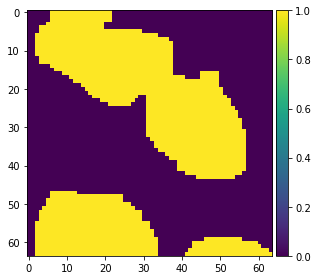

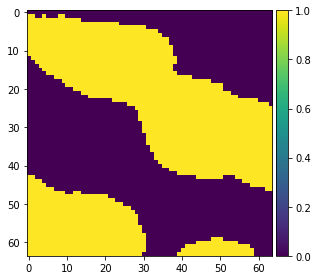

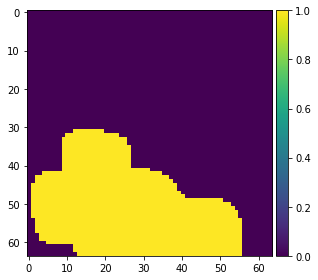

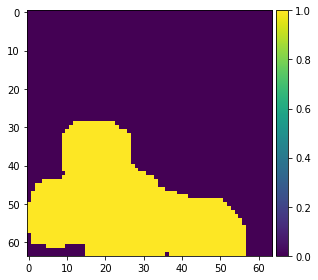

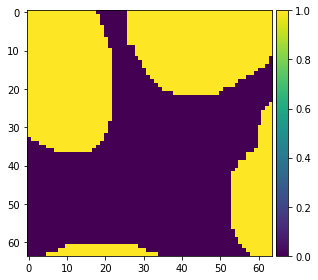

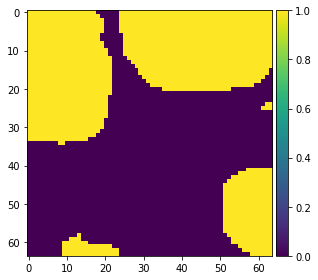

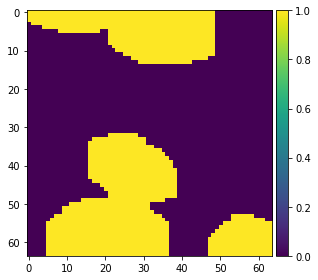

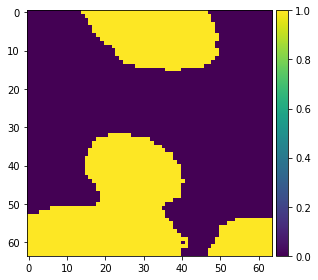

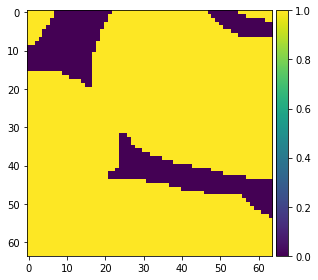

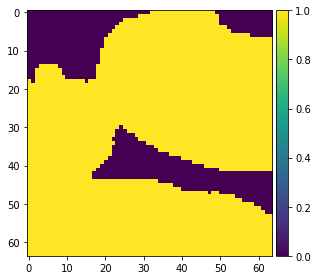

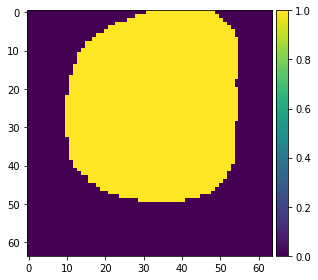

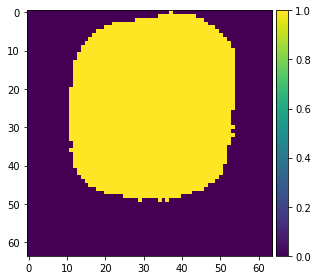

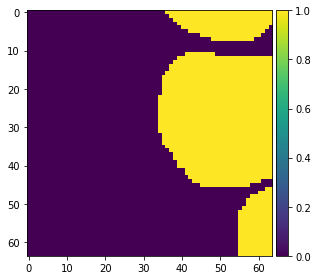

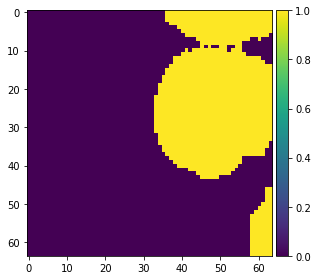

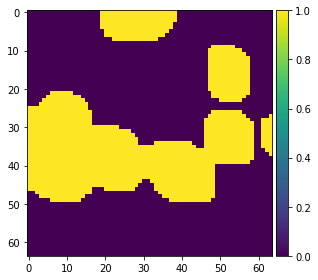

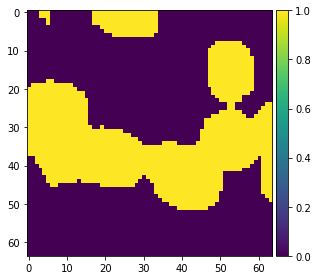

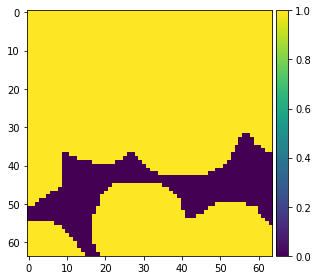

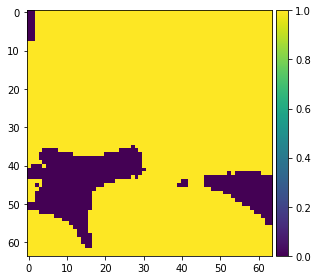

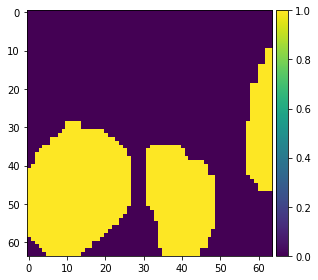

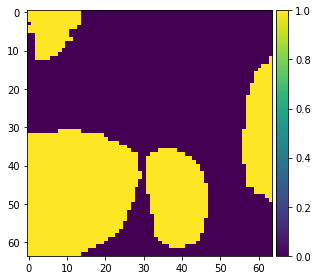

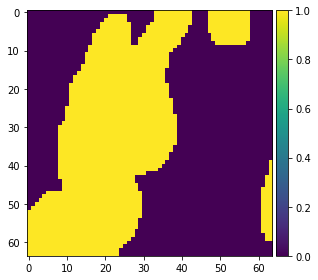

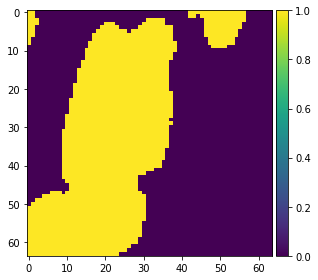

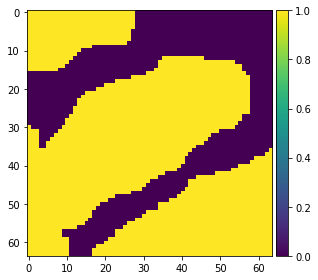

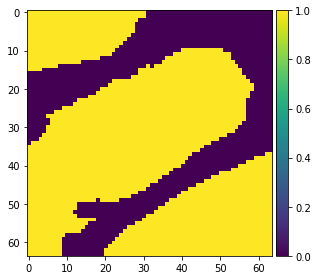

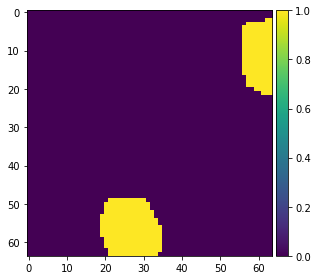

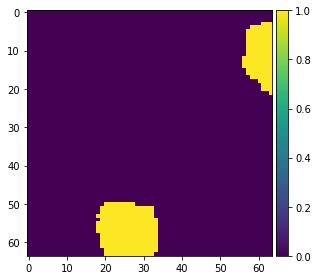

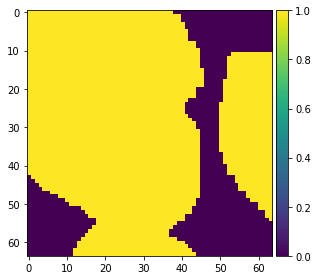

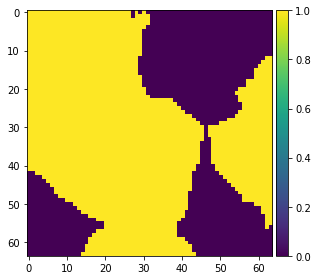

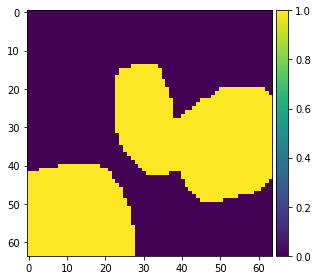

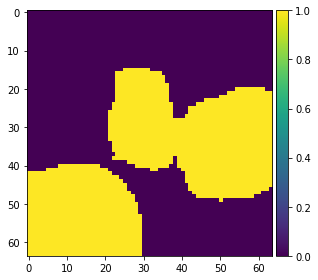

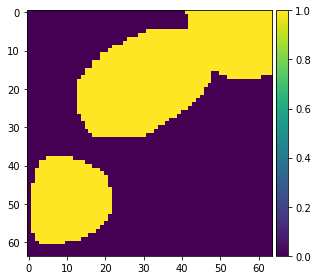

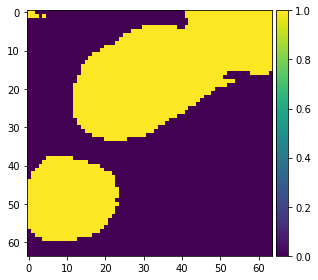

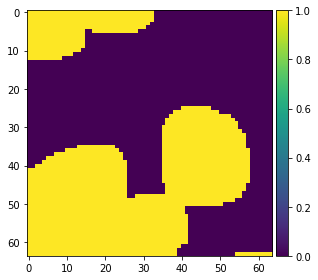

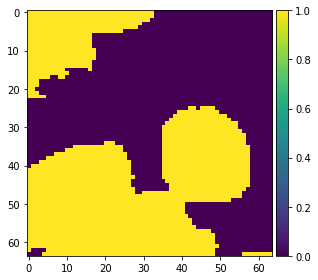

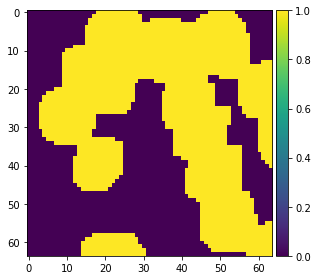

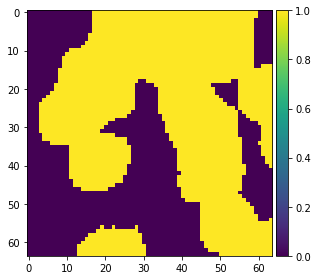

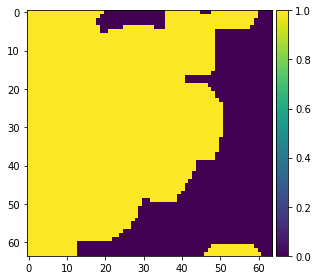

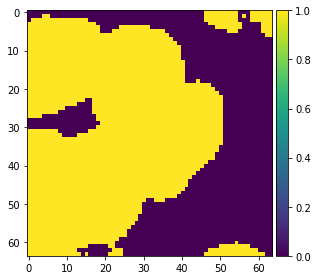

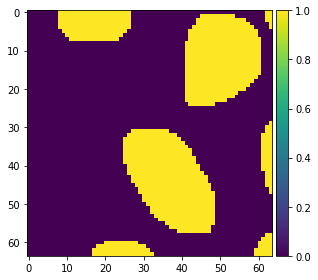

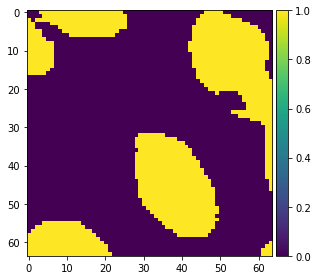

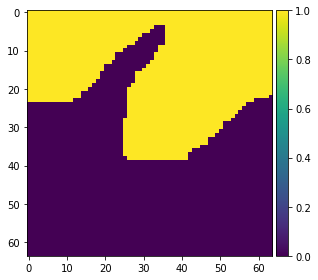

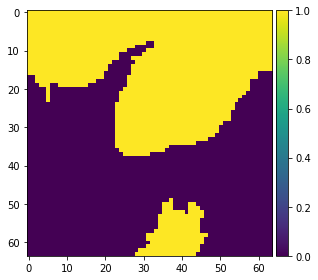

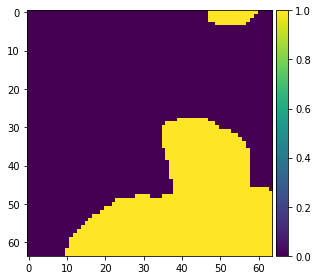

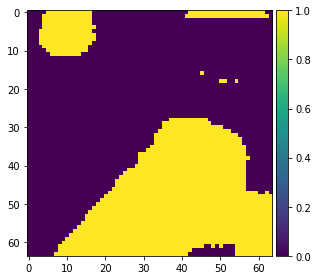

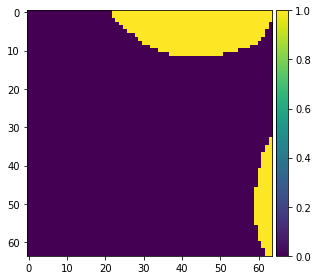

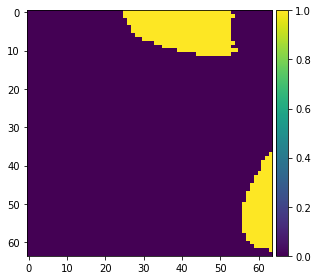

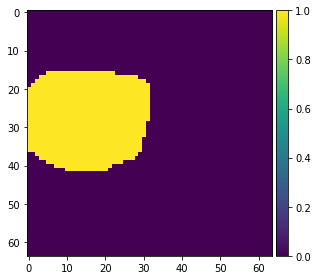

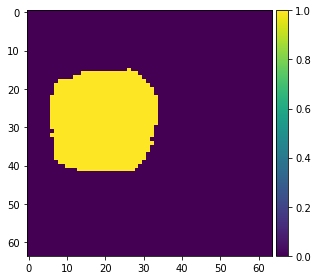

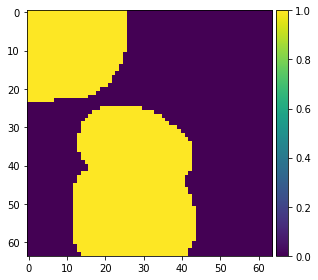

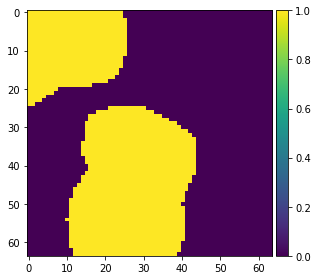

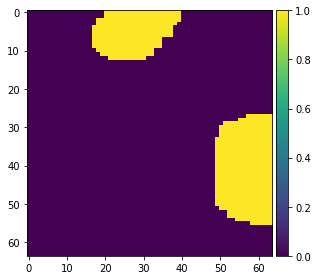

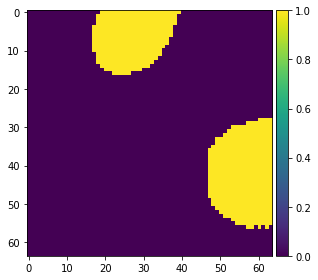

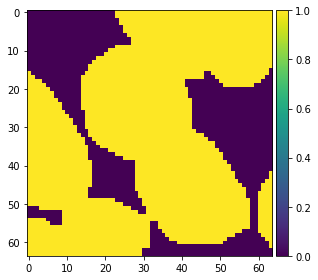

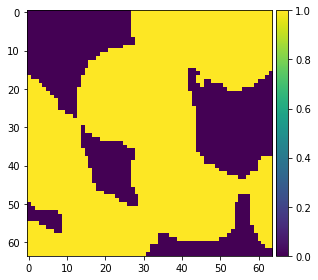

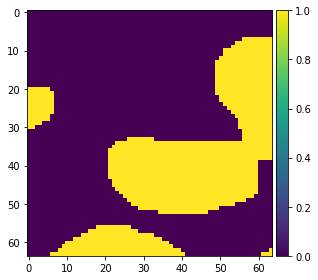

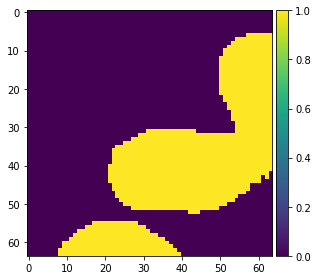

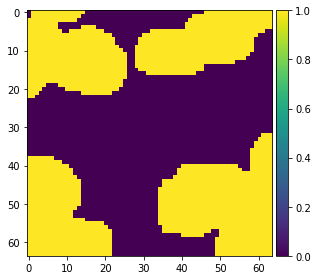

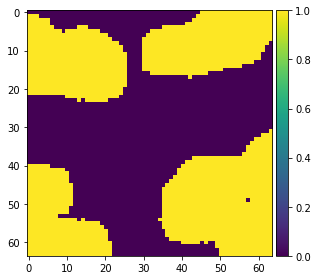

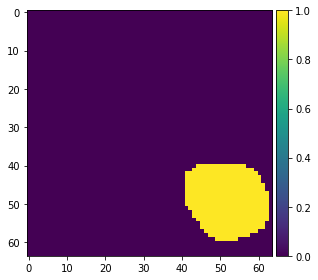

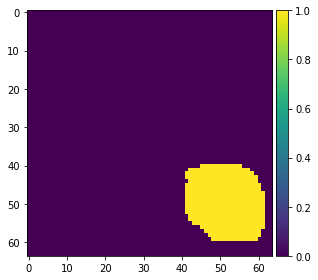

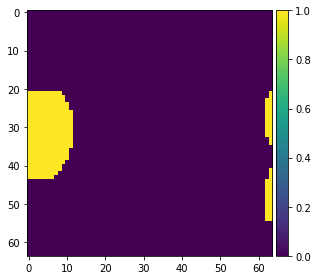

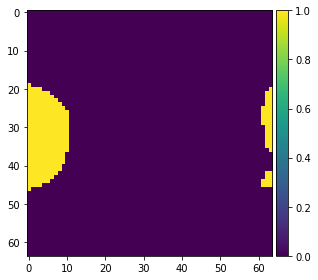

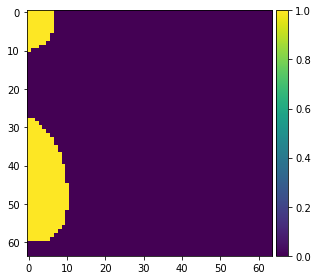

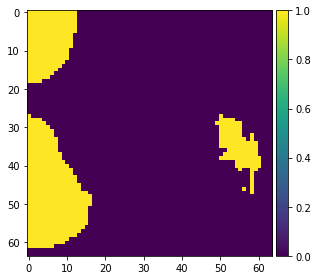

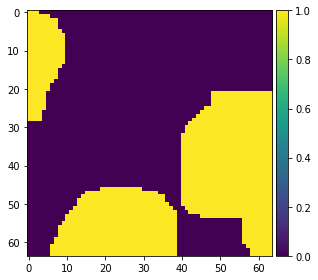

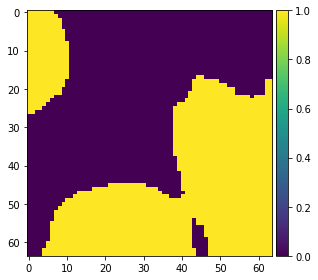

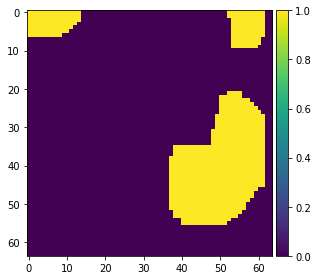

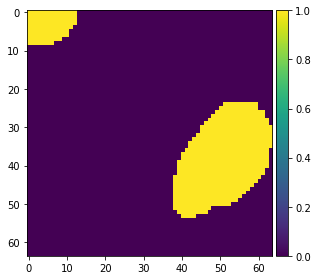

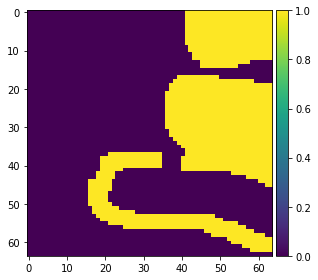

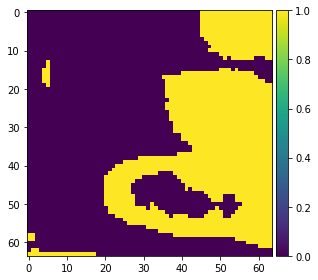

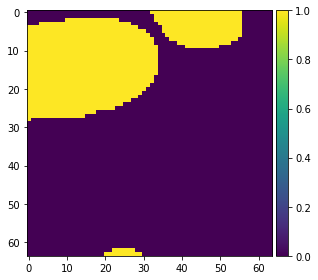

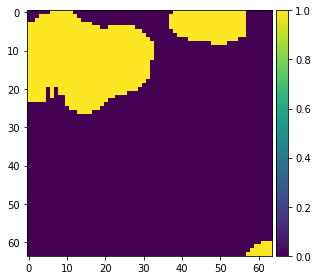

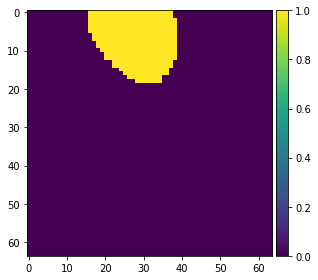

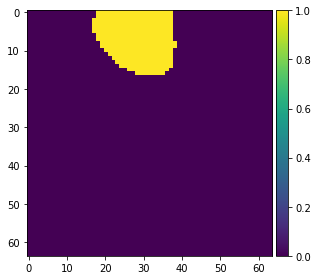

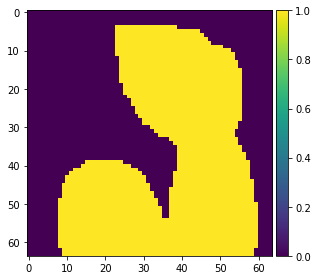

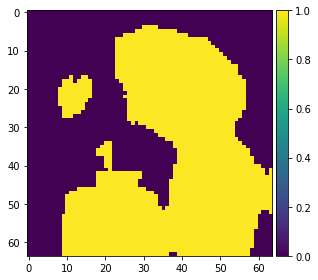

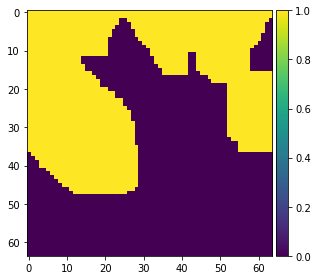

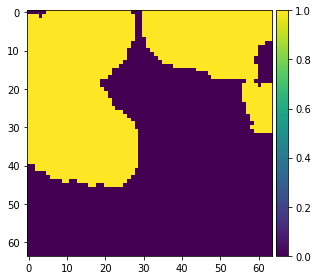

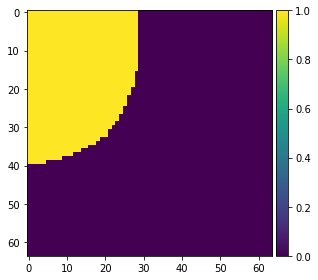

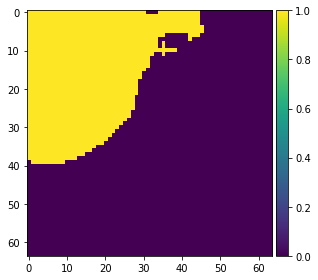

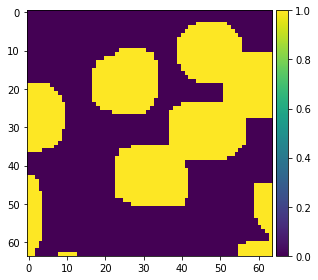

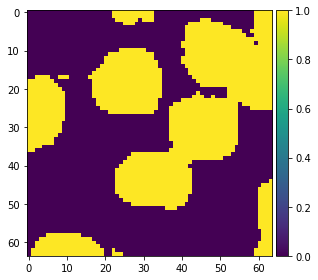

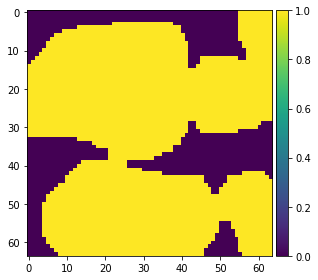

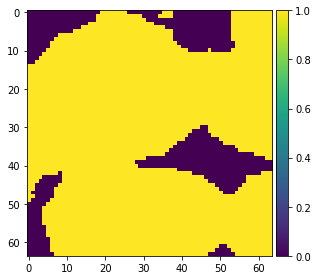

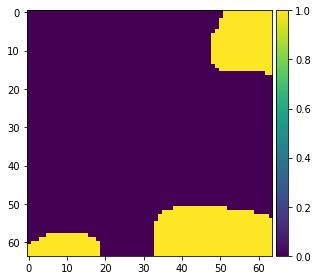

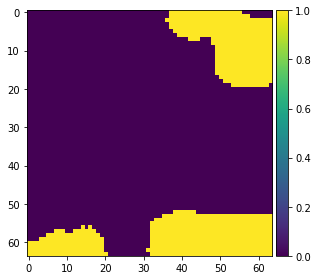

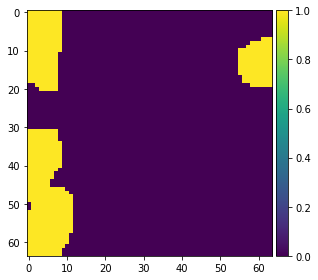

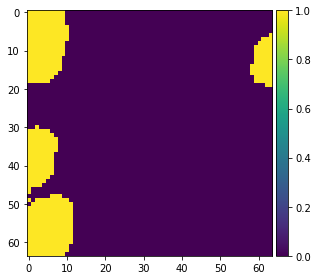

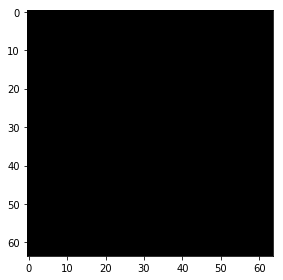

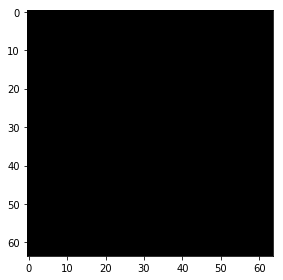

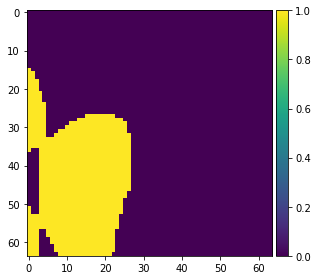

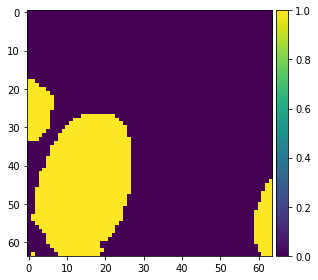

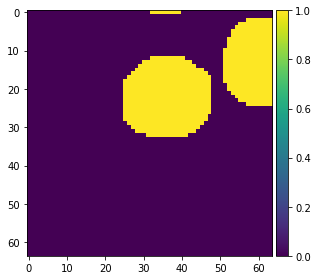

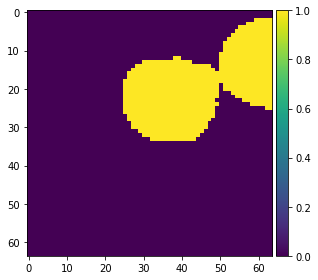

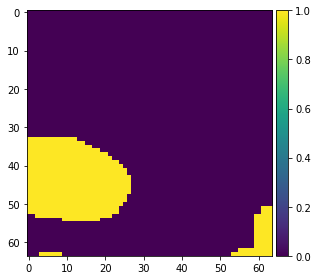

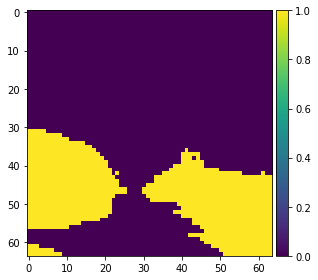

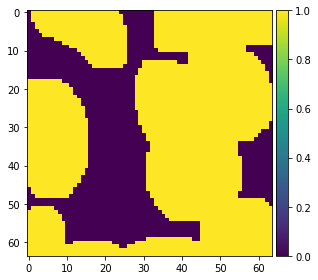

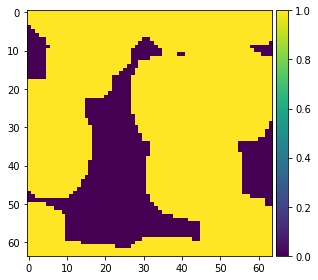

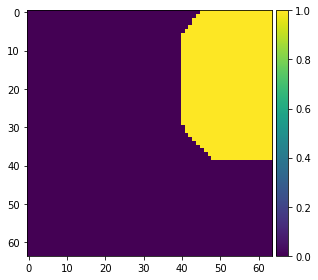

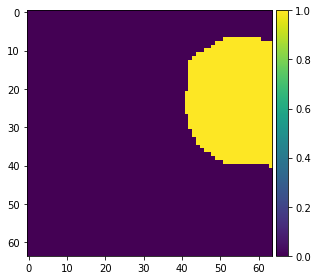

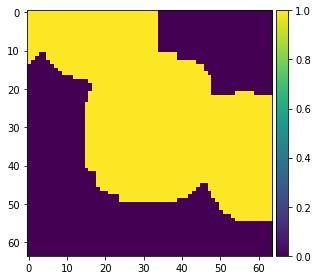

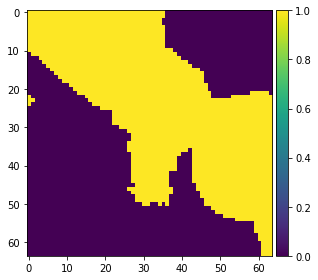

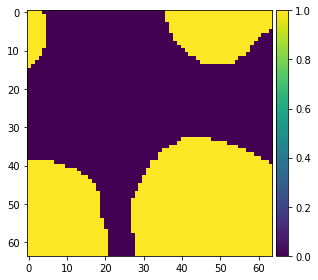

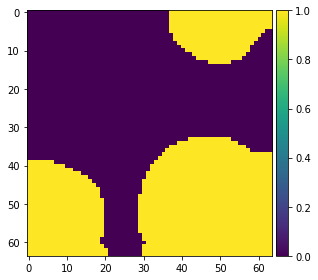

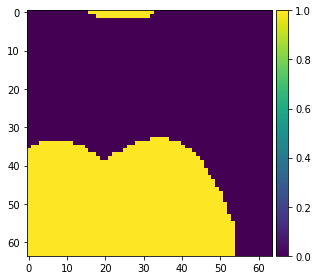

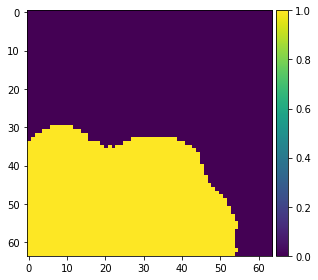

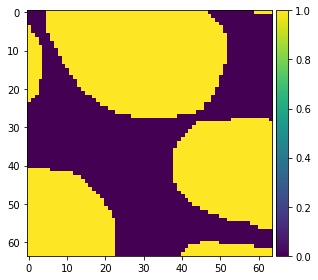

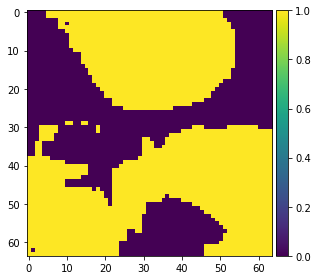

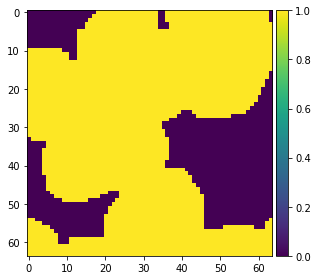

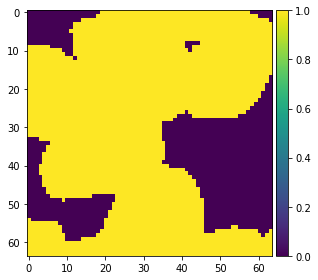

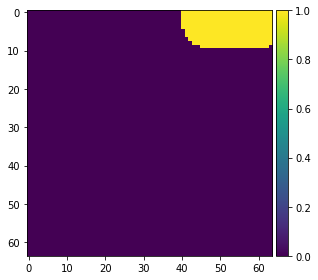

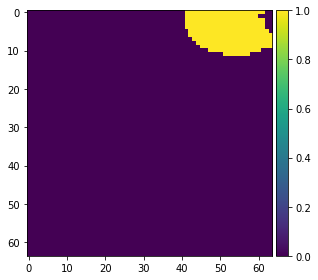

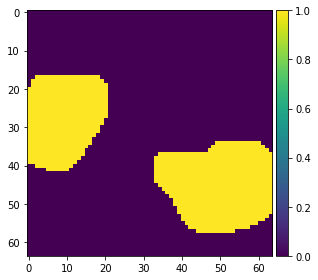

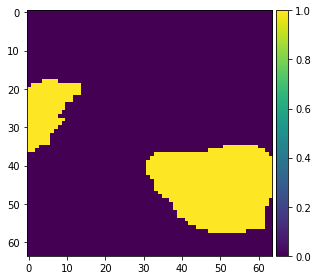

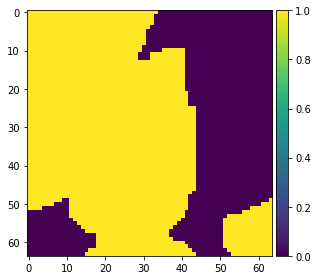

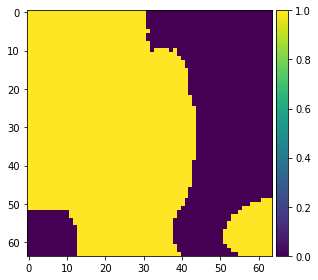

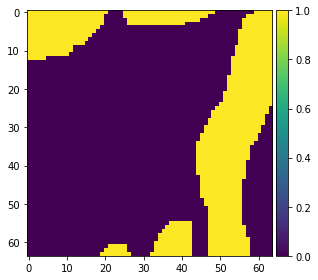

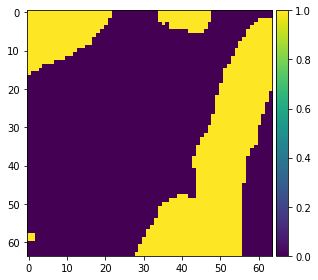

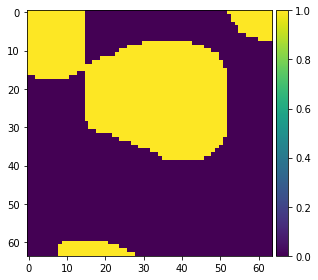

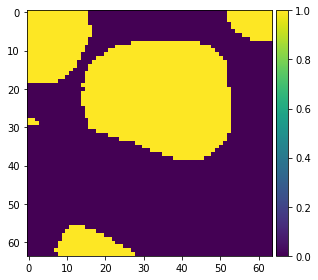

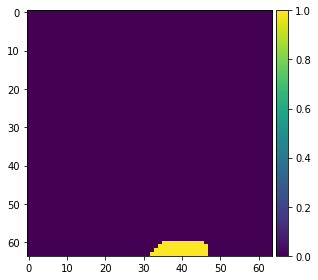

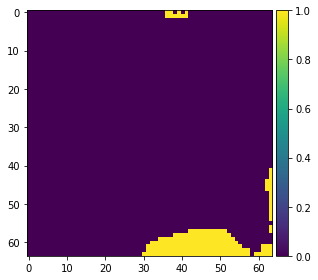

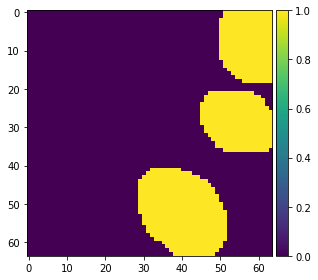

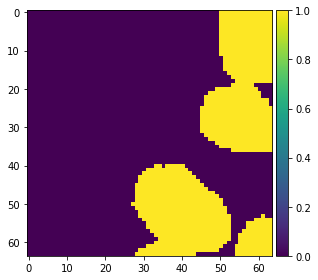

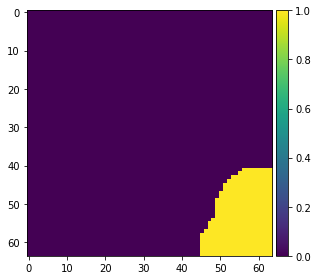

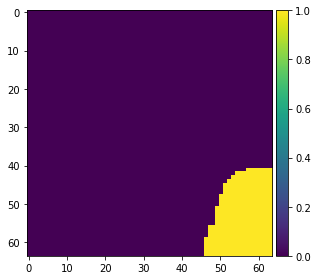

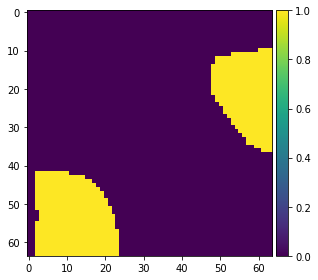

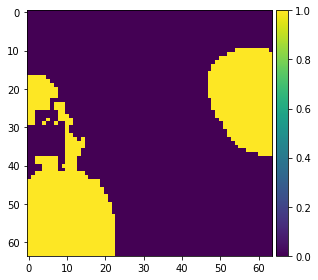

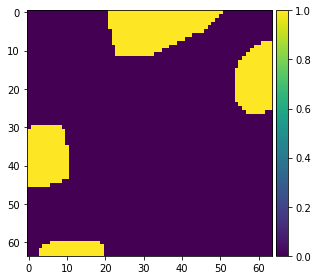

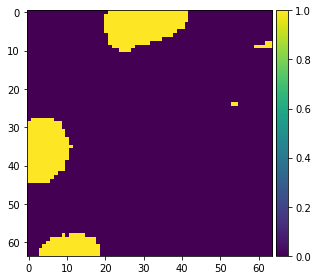

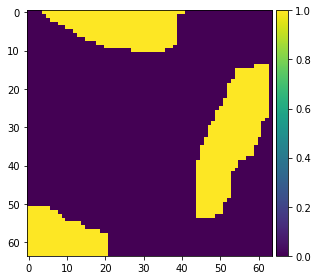

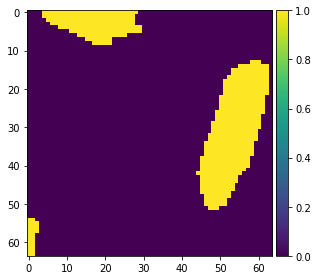

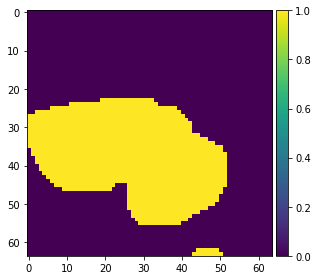

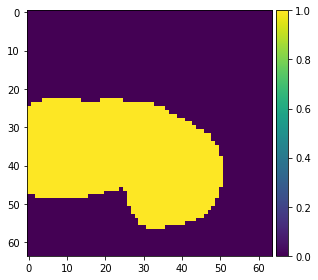

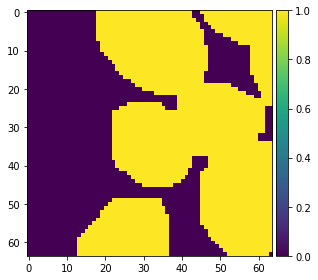

KeyboardInterrupt: 

In [24]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
for ix in range(0,len(preds_val_t) -1):
    imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    plt.show()
    imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


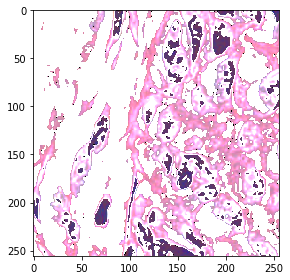

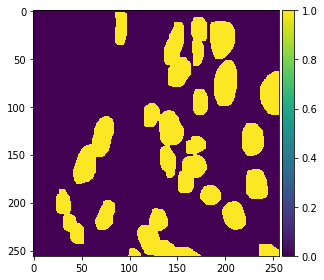

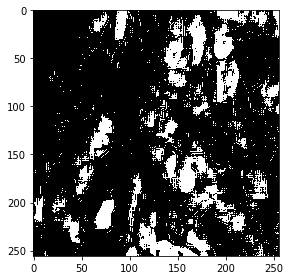

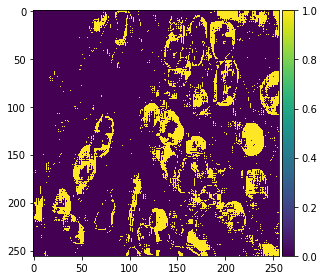

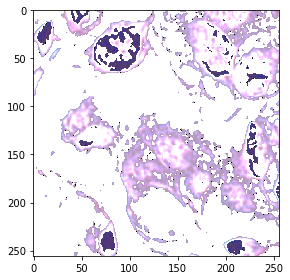

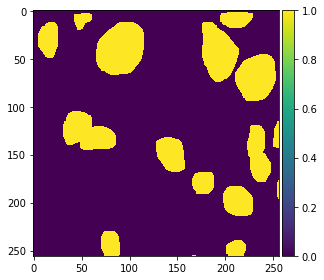

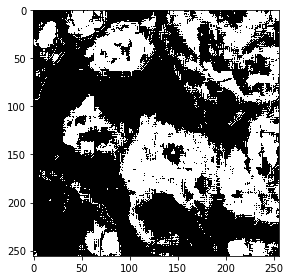

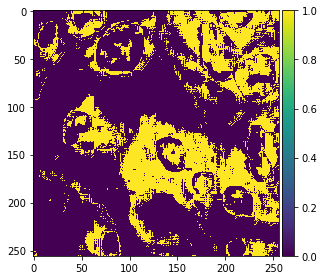

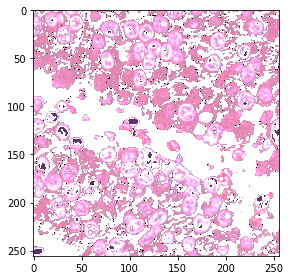

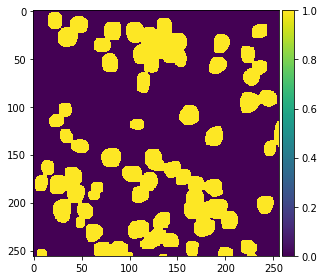

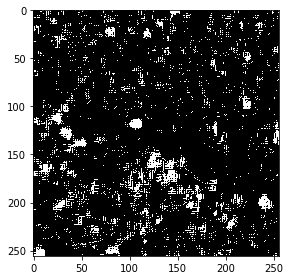

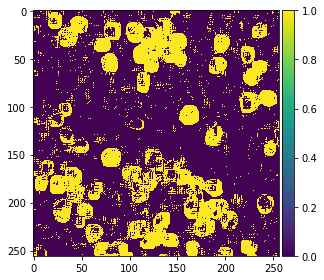

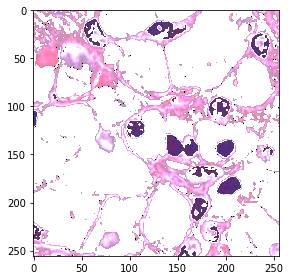

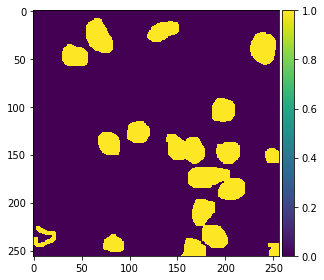

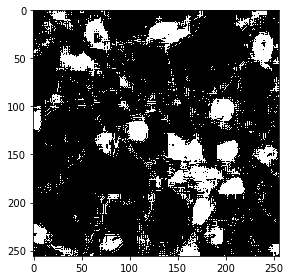

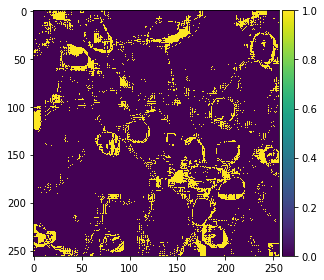

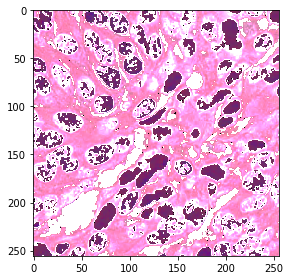

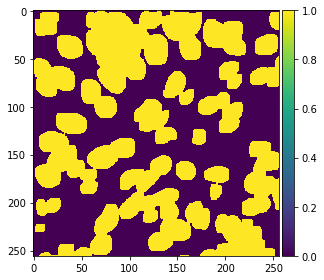

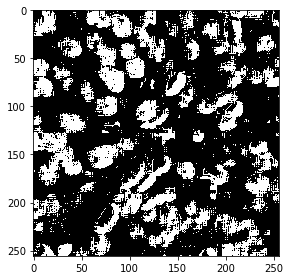

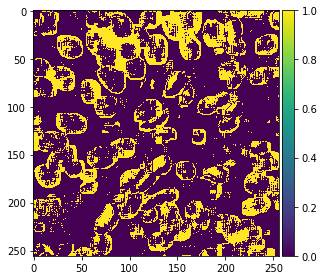

In [15]:
ids = [x[:-4] for x in os.listdir('data/images/1000x1000')]
dummy = np.zeros((len(ids), 1))
X_train_ids, X_test_ids, _, _ = cross_validation.train_test_split(ids, dummy, test_size=0.15, random_state=42)


def merge_and_show(ix):
    file = X_test_ids[ix]
    x_merged = None
    y_merged = None
    pred_merged = None
    for i in range(0,4):
        x_merged_row = None
        y_merged_row = None
        pred_merged_row = None
        for j in range(0,4):
            x_img = normalize_rgb(imread('data/images/64x64/test/' + file + '-' + str(i) + '-' + str(j) + '.png'))
            if x_merged_row is None:
                x_merged_row = x_img
            else:
                x_merged_row = np.concatenate((x_merged_row, x_img), axis=1)
            mask = np.load('data/masks/64x64/test/' + file + '-' + str(i) + '-' + str(j) + '.npy')
            if y_merged_row is None:
                y_merged_row = mask
            else:
                y_merged_row = np.concatenate((y_merged_row, mask), axis=1)
            pred = model.predict(np.array([x_img]))
            pred = (pred > 0.5)
            if pred_merged_row is None:
                pred_merged_row = pred[0]
            else:
                pred_merged_row = np.concatenate((pred_merged_row, pred[0]), axis=1)
        if x_merged is None:
            x_merged = x_merged_row
        else:
            x_merged = np.concatenate((x_merged, x_merged_row))
        if y_merged is None:
            y_merged = y_merged_row
        else:
            y_merged = np.concatenate((y_merged, y_merged_row))
        if pred_merged is None:
            pred_merged = pred_merged_row
        else:
            pred_merged = np.concatenate((pred_merged, pred_merged_row))
    pred_merged = pred_merged.reshape((pred_merged.shape[0], pred_merged.shape[1]))
    imshow(x_merged)
    plt.show()
    imshow(y_merged)
    plt.show()
    imshow(pred_merged)
    plt.show()
    imshow(pred_merged ^ y_merged)
    plt.show()

# for ix in range(0, 3):
#     imshow(X_test[ix])
#     plt.show()
#     imshow(np.squeeze(y_test[ix]))
#     plt.show()
#     imshow(np.squeeze(preds_test_t[ix]))
#     plt.show()
#     imshow(np.squeeze(preds_test_t[ix] ^ y_test[ix]))
#     plt.show()
    
for i in range(0, len(X_test_ids)):
    merge_and_show(i)